In [1]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary, binary_shift_P_vs_U, welch_shift_P_vs_U
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# load basic ephys
target_folder = '/root/capsule/scratch/manuscript/F_basicephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', 'basic_ephys')
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

In [3]:
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
# antidromic data
version = 'PrL_S1'
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

antidromic_df.rename(columns={'unit': 'unit_id'}, inplace=True)
antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit_id', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit_id'], how='left')
combined_tagged_units['tier_1'].fillna(False, inplace=True)
combined_tagged_units['tier_2'].fillna(False, inplace=True)
combined_tagged_units['tier_1_long'].fillna(False, inplace=True)
combined_tagged_units['tier_2_long'].fillna(False, inplace=True)


Applying conditional bounds for isi_violations
 - isi_violations: 18300 -> 8346 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8346 -> 5873 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5873 -> 5850 units passed
Applying bounds for sd: [0, 0.3]
 - sd: 5850 -> 2969 units passed
Applying conditional bounds for y_loc
 - y_loc: 2969 -> 2410 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto rows after filtering: 412
Number of non-opto rows after filtering: 2410


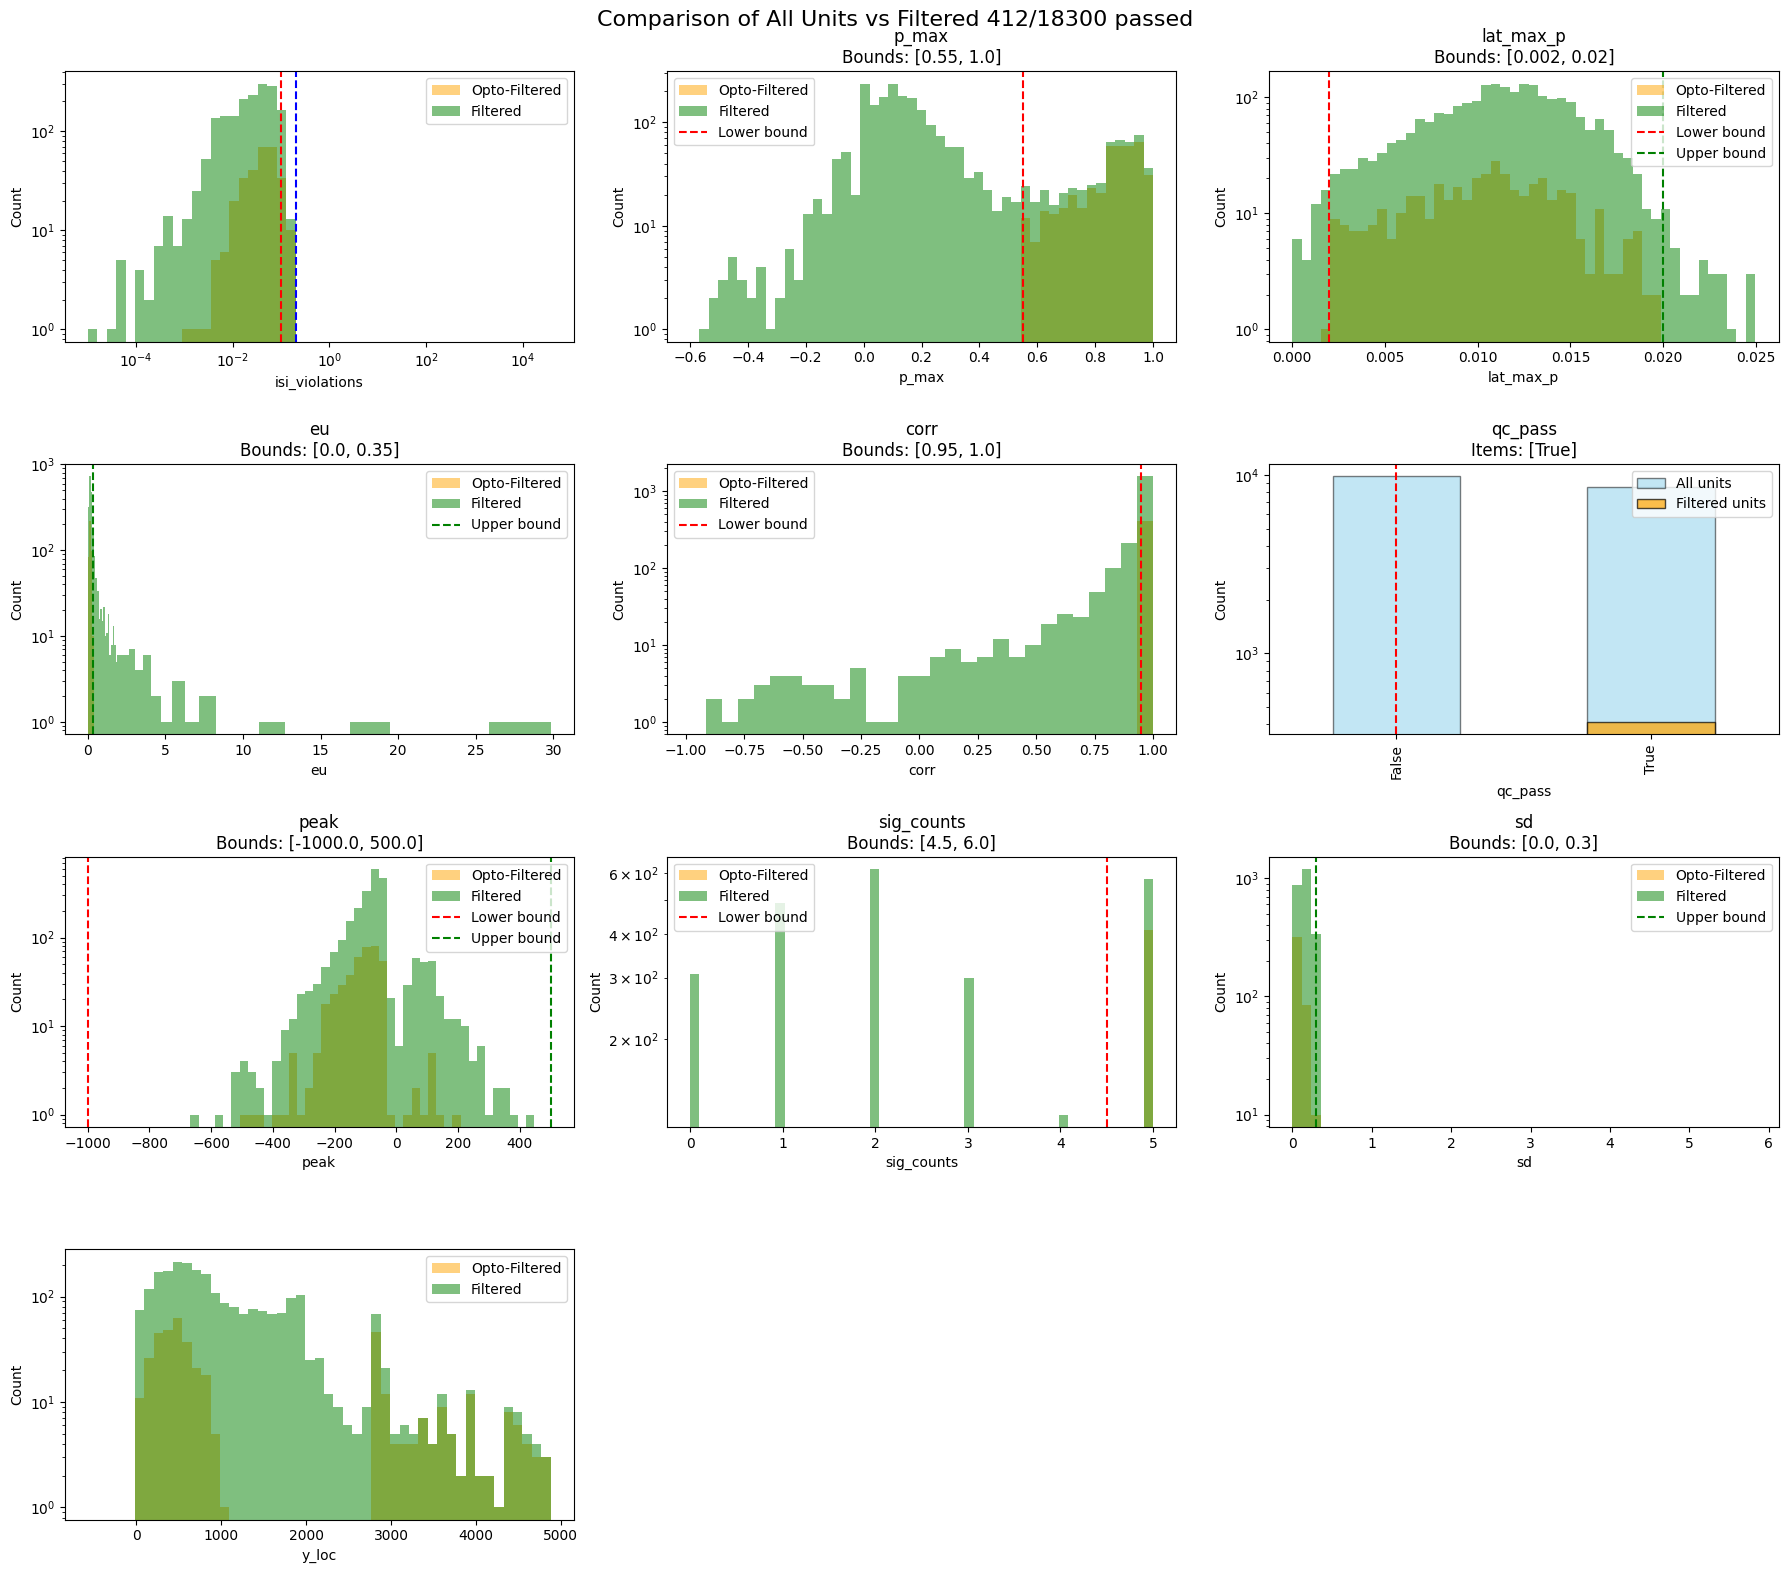

In [4]:
density = False
criteria_name = 'basic_ephys_all'
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
    
combined_tagged_units_filtered, combined_tagged_units, fig, axes = apply_qc(combined_tagged_units, constraints, density=density, plot_all=False)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
combined_tagged_units_filtered.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_filtered['unit_id'] = combined_tagged_units_filtered['unit_id'].apply(to_str_intlike)


In [5]:

fig.savefig(fname=os.path.join(target_folder, f'unit_quality_metrics_summary_density_{density}.pdf'))
fig.savefig(fname=os.path.join(target_folder, f'unit_quality_metrics_summary_density_{density}.svg'))

In [6]:
features_combined = basic_ephys_df.merge(combined_tagged_units_filtered, on=['session', 'unit_id'], how='inner')

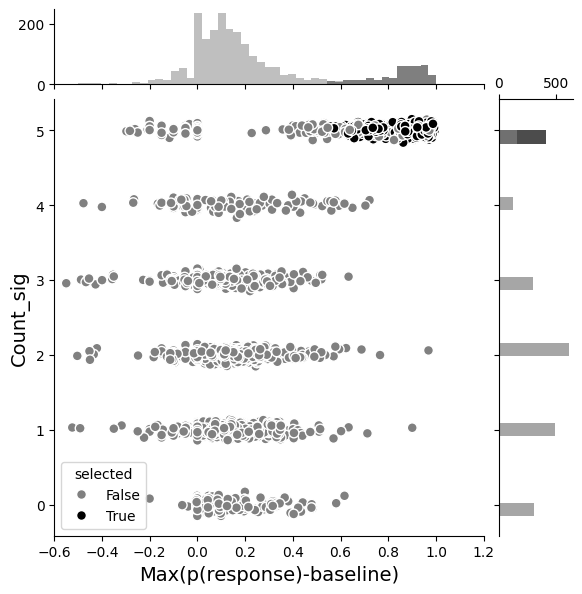

In [7]:

# opto tagged vs not
# Define color palette for groups
palette = {True: "k", False: "gray"}
x_col = 'p_max'
y_col = 'sig_counts'

combined_tagged_units_plot = combined_tagged_units.copy()
combined_tagged_units_plot[y_col] = combined_tagged_units_plot[y_col]  + np.random.normal(0, 0.05, size=len(combined_tagged_units_plot[y_col]))  # add jitter to y-axis for better visibility

# Create JointGrid
g = sns.JointGrid(data=combined_tagged_units_plot[combined_tagged_units['selected_qc_only']], x=x_col, y=y_col, hue='selected', palette=palette)
g.plot_joint(
    sns.scatterplot,
    edgecolor='white',
    linewidth=1,
    alpha=1,
    s=50   # increase marker size if needed
)
# for coll in g.ax_joint.collections:
#     fc = coll.get_facecolor()
#     fc[:, -1] = 1   # force alpha channel to 1
#     coll.set_facecolor(fc)
#     coll.set_edgecolor("white")

# Add scatter plot in the center
# g.plot_joint(sns.scatterplot, alpha=1)

g.ax_joint.set_xlim(-0.6, 1.2)

g.ax_joint.set_xlabel('Max(p(response)-baseline)', fontsize=14)
g.ax_joint.set_ylabel('Count_sig', fontsize=14)

# Add histograms manually for each group
p_max_bins = np.linspace(0, 1, 30)
y_bins = np.linspace(combined_tagged_units_plot[combined_tagged_units['selected_qc_only']][y_col].min(), combined_tagged_units[combined_tagged_units['selected_qc_only']][y_col].max(), 30)
x_bins = np.linspace(-0.6, 1, 50)
for qc_val, color in palette.items():
    subset = combined_tagged_units[combined_tagged_units['selected_qc_only'] & (combined_tagged_units['selected'] == qc_val)]
    # Horizontal histogram for x-axis (default orientation)
    ax = g.ax_marg_x
    ax.hist(subset[x_col], bins=x_bins, color=color, alpha=0.5, edgecolor='none')

    # **VERTICAL histogram for y-axis** using orientation="horizontal"
    ax = g.ax_marg_y
    ax.hist(subset[y_col], bins=y_bins, color=color, alpha=0.7, edgecolor='none',  orientation='horizontal')
    # sns.histplot(y=subset['lat_max_p'], ax=g.ax_marg_y, bins=lat_max_p_bins, color=color, alpha=0.5, edgecolor='none')
# g.ax_marg_y.tick_params(left=True, labelleft=True)
g.ax_marg_y.set_axis_on()

g.ax_marg_y.spines["top"].set_visible(True)
g.ax_marg_y.tick_params(
    top=True,
    labeltop=True
)

g.ax_marg_x.set_axis_on()

g.ax_marg_x.spines["left"].set_visible(True)
g.ax_marg_x.tick_params(
    left=True,
    labelleft=True
)


plt.savefig(os.path.join(target_folder, f'opto_pass_{x_col}_{y_col}_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'opto_pass_{x_col}_{y_col}_{criteria_name}.svg'), dpi=300, bbox_inches='tight')
# Show plot
plt.show()



In [8]:
np.sum((combined_tagged_units['selected'] == True))

np.int64(412)

In [9]:
features_combined.columns

Index(['session', 'unit_id', 'bl_mean', 'response_rate', 'response_bias',
       'response_diff', 'bl_diff', 'outcome_diff', 'outcome_diff_abs',
       'bl_response_corr', 'go_mean', 'no_go_mean', 'response_lat',
       'response_isi', 'be_filter', 'burst_ratio', 'burst_bi_dp', 'acg',
       'acg_bl', 'r_squared', 'sd_mean', 'pc_1', 'pc_2', 'pc_3', 'qc_pass',
       'opto_tagged', 'in_df', 'trial_count', 'p_max', 'p_mean', 'sig_counts',
       'lat_max_p', 'isi_violations', 'snr', 'amplitude_cutoff',
       'presence_ratio', 'eu', 'corr', 'amp', 'amp_raw', 'peak', 'peak_raw',
       'wf', 'wf_raw', 'wf_aligned', 'wf_2d', 'wf_2d_raw', 'probe', 'y_loc',
       'rec_side', 'top', 'bottom', 'tag_loc', 'fr', 'decoder', 'all_p_max',
       'all_p_mean', 'all_lat_max_p', 'all_corr', 'all_eu', 'all_sig_counts',
       'x_ccf', 'y_ccf', 'z_ccf', 'sd', 'rec_len', 'p_auto_inhi',
       't_auto_inhi', 'p_collision', 't_collision', 'p_antidromic',
       't_antidromic', 'tier_1', 'tier_2', 'tier_1_

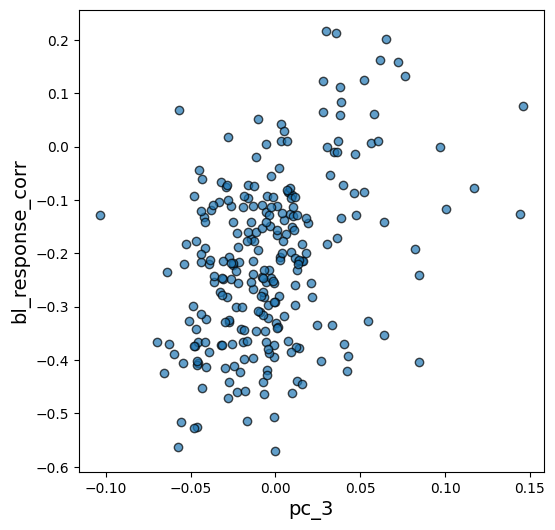

In [10]:
x_val = 'pc_3'
y_val = 'bl_response_corr'
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(features_combined[x_val], features_combined[y_val], alpha=0.7, edgecolor='k')
ax.set_xlabel(x_val, fontsize=14)
ax.set_ylabel(y_val, fontsize=14)
plt.savefig(os.path.join(target_folder, f'{x_val}_vs_{y_val}_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

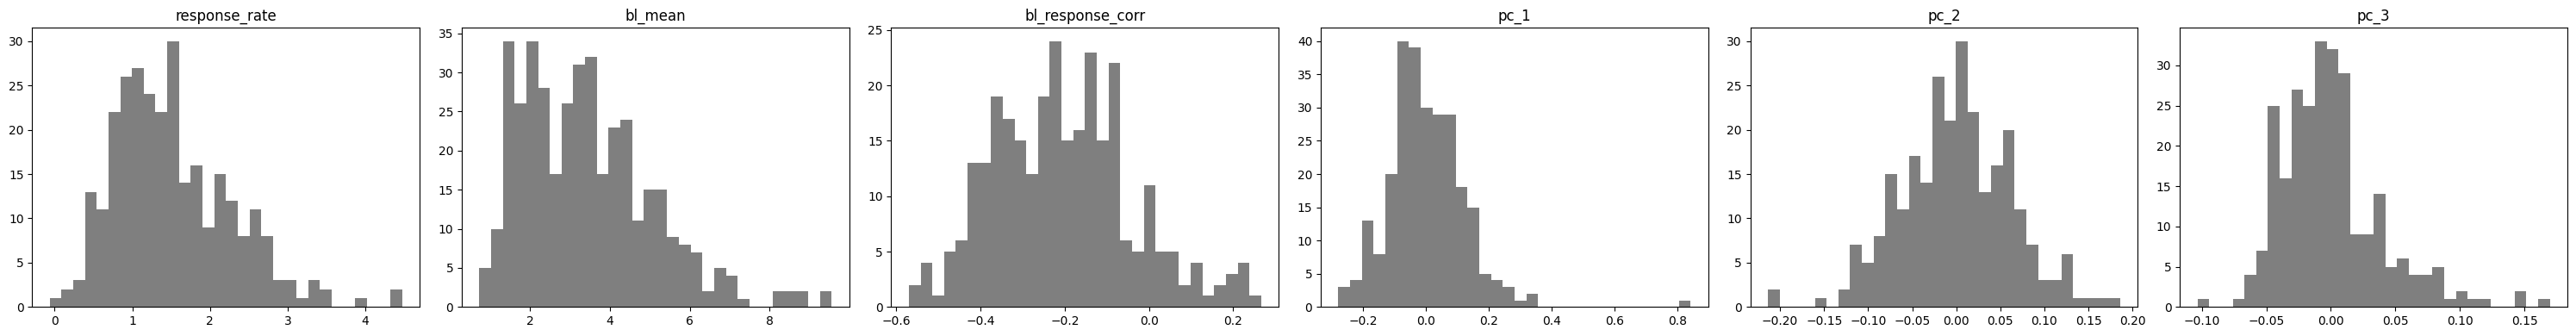

In [11]:
focus_features = ['response_rate', 'bl_mean', 'bl_response_corr', 'pc_1', 'pc_2', 'pc_3']
# histograms of all-focus cols
fig, axes = plt.subplots(1, len(focus_features), figsize=(5 * len(focus_features), 4))
for i, col in enumerate(focus_features):
    axes[i].hist(features_combined[col], facecolor='k', edgecolor=None, alpha=0.5, bins=30)
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'focus_features.pdf'), dpi=300, bbox_inches='tight')


## Plot distribution in space

In [12]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
# mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]

# --- 3D anatomical points ---
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

In [13]:
# precompute mesh contours for each plane (for speed)
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_mm, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

In [14]:
from matplotlib.colors import LinearSegmentedColormap


# Custom single-color colormap: light gray → full red
colors = [(0.4, 0.4, 0.4), (0.6, 0.3, 0.3), (1.0, 0.0, 0.0)]  # RGB for low/high
cmap = LinearSegmentedColormap.from_list('custom_red', colors)

In [15]:
# perform spatial dependence analysis for all features
spatial_dependence_results = {}
for feature_name in basic_ephys_df.columns:
    # if columns is numetric
    if features_combined[feature_name].dtype not in [np.float64, np.float32, np.int64, np.int32]:
        continue
    values = features_combined[feature_name].values
    result = spatial_dependence_summary(
        ccfs,
        values,
        k_neighbors=30,
        n_splits=5,
        permutations=2000,
        seed=42,
    )
    spatial_dependence_results[feature_name] = result

In [16]:
# multiple comparison correction (FDR)
from statsmodels.stats.multitest import multipletests
# for knn
p_values = [spatial_dependence_results[feat]['cv_predictability_knn']['p_value_permutation'] for feat in focus_features]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(focus_features):
    spatial_dependence_results[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# for trend
p_values = [spatial_dependence_results[feat]['linear_trend']['p_value_permutation_r2'] for feat in focus_features]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(focus_features):
    spatial_dependence_results[feature_name]['linear_trend']['p_value_permutation_r2_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['linear_trend']['significant_fdr'] = reject[i]
# save results
# save results
results_file = os.path.join(target_folder, f'spatial_dependence_results_{criteria_name}.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(spatial_dependence_results, f)

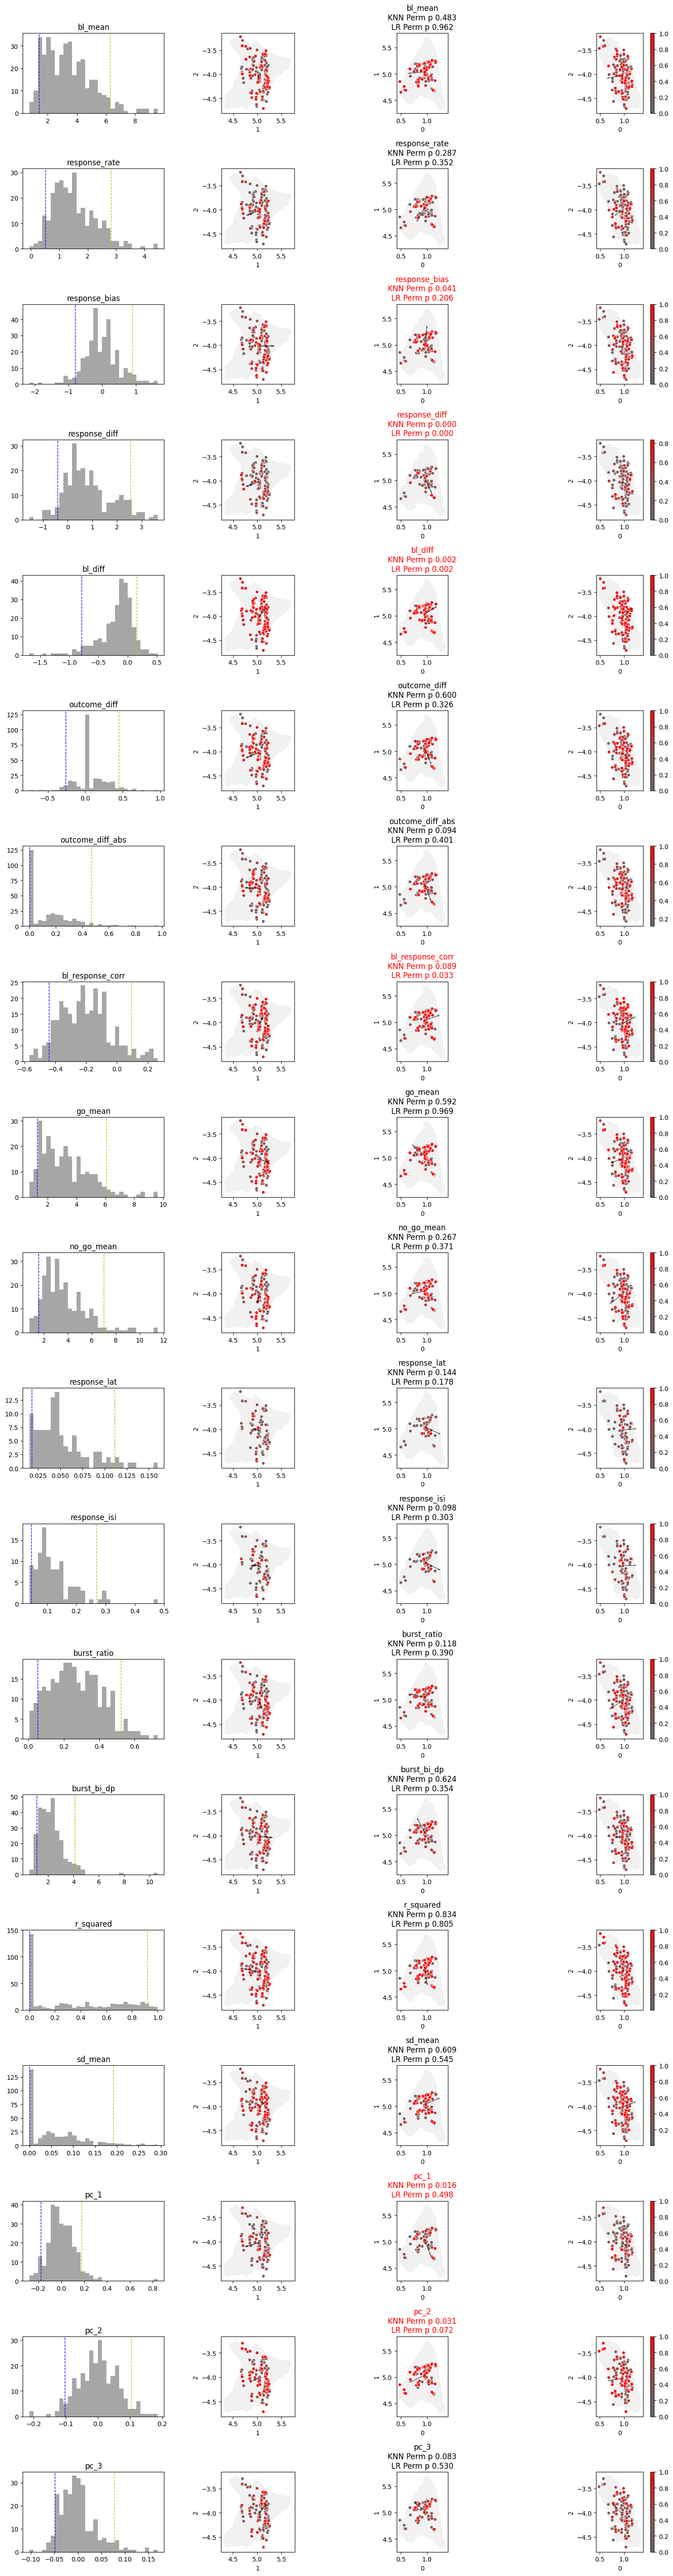

In [19]:
from matplotlib.colors import Normalize
from scipy.stats import rankdata
# -------------------------------------------------------------------------
# Main figure: plot CCA behavioral components in CCF space
# -------------------------------------------------------------------------
filter = features_combined['isi_violations'].values < 0.5
# CCF coordinates and planes
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
bin_num = 4
# Precompute high-resolution mesh contours
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}
plot_features = spatial_dependence_results.keys()
fig, axes = plt.subplots(len(plot_features), 4, figsize=(15, 3*len(plot_features)))

for ind, feature in enumerate(plot_features):
    ax = axes[ind, 0]
    color_code = features_combined[feature].values
    ax.hist(color_code, bins=30, color='gray', alpha=0.7)
    ax.set_title(feature)
    valid_ind  = ~np.isnan(color_code)
    top_90 = np.quantile(color_code[valid_ind], 0.95)
    bottom_10 = np.quantile(color_code[valid_ind], 0.05)
    ax.axvline(top_90, color='y', linestyle='--', linewidth=1)
    ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
    color_code_nl = color_code.copy()
    color_code_nl[color_code > top_90] = top_90
    color_code_nl[color_code < bottom_10] = bottom_10
    color_code_nl = (color_code_nl - bottom_10) / (top_90 - bottom_10)  # Normalize color code to [0, 1] using 10-90% quantiles
    # change to rank
    # color_code_nl = rankdata(color_code_nl) / len(color_code_nl)
    sort_ind = np.argsort(color_code_nl)
    # sort_ind = np.random.permutation(sort_ind)  # randomize the order within same color
    # bin_edges = np.quantile(color_code, np.linspace(0, 1, bin_num + 1))
    # ax = axes[ind, -1]
    # for b in range(bin_num):
    #     bin_mask = (color_code >= bin_edges[b]) & (color_code < bin_edges[b + 1])
    #     mean_wf = np.nanmean(all_wfs_nl[filter][bin_mask], axis=0)
    #     mean_sem = np.nanstd(all_wfs_nl[filter][bin_mask], axis=0) / np.sqrt(np.sum(bin_mask))
    #     ax.plot(pc_time, mean_wf, label=f'Bin {b + 1} ({bin_edges[b]:.2f}-{bin_edges[b + 1]:.2f})', 
    #             color=cmap(b / (bin_num - 1)), linewidth=2)
    #     ax.fill_between(pc_time, mean_wf - mean_sem, mean_wf + mean_sem, color=cmap(b / (bin_num - 1)), 
    #                     alpha=0.3)
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # Plot the mesh
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
        # Plot the points
        sc = ax.scatter(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], c=color_code_nl[sort_ind], cmap=cmap, s=25, edgecolor=[1, 1, 1], alpha=1, linewidth=0.5)
        # add estimated arrow from linear trend
        coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[planes[plane][0]],
            arrow_start[planes[plane][1]],
            arrow_vec[planes[plane][0]],
            arrow_vec[planes[plane][1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )

        if plane == 'hor':
            if spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation']<0.05 or spatial_dependence_results[feature]['linear_trend']['p_value_permutation_r2']<0.05:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{feature}\n"
                f"KNN Perm p {spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation']:.3f}\n"
                f"LR Perm p {spatial_dependence_results[feature]['linear_trend']['p_value_permutation_r2']:.3f}",
                color=title_color
            )
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        # set equal aspect ratio
        ax.set_aspect('equal')
        # if planes[plane][1] == dv: 
        #     ax.invert_yaxis()
            # ax.set_ylim(-5, -3)
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
            

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'basic_ephys_feature_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'basic_ephys_feature_in_space_{criteria_name}.svg'), dpi=300, bbox_inches='tight')

In [15]:
# plot all autocorrelograms
auto_corr = features_combined['acg_bl'].values

In [17]:
auto_corr[0]

array([-6.63057114e-02,  1.75233710e-03,  4.26789725e-02,  4.77265335e-02,
        3.60167054e-02,  2.56144112e-02,  5.54539204e-02,  5.32626610e-02,
        1.65183743e-02,  1.75317253e-02,  1.93367976e-02, -3.62909257e-03,
        2.18965338e-02,  2.09074779e-02,  1.07683532e-02,  3.16774402e-02,
        1.61929201e-02,  1.61864553e-02,  2.26087400e-02,  9.55350120e-03,
        1.64002319e-02,  1.94581812e-02,  9.19415299e-03,  2.53589879e-02,
        1.47081540e-02,  1.41097499e-02,  2.87101227e-03, -1.28737451e-02,
       -2.89695994e-03,  3.15929277e-03, -9.22084226e-05,  7.80573247e-03,
        4.01643806e-03,  7.53462305e-03,  4.41998896e-03,  1.05742557e-02,
       -9.60271321e-03,  3.69619518e-03,  1.57018816e-02,  3.61262916e-03])

In [16]:
auto_inhi_bin = 0.05
window_length = 2

x_vals = np.array(range(int(window_length/auto_inhi_bin))) * auto_inhi_bin

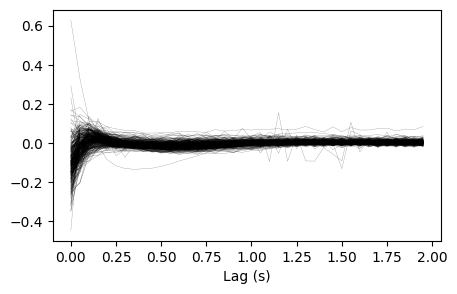

In [14]:
fig = plt.figure(figsize=(5, 3))
plt.plot(x_vals, np.array(auto_corr.tolist()).T, color='k', alpha=0.5, linewidth=0.2);
plt.xlabel('Lag (s)')
fig.savefig(os.path.join(target_folder, f'basic_ephys_all_autocorr_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

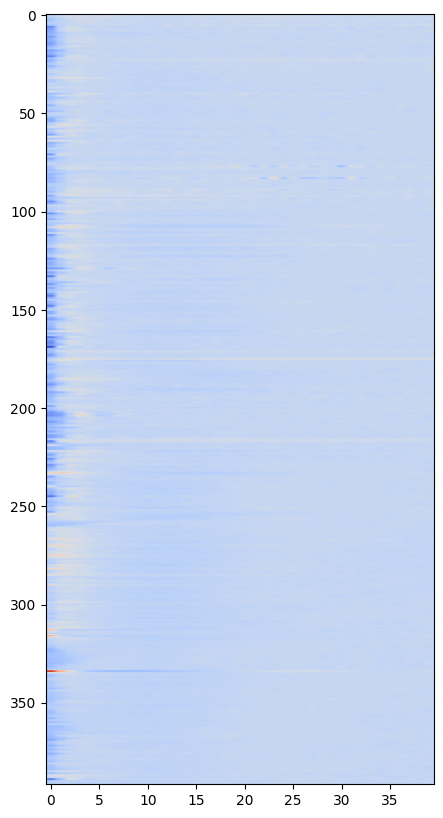

In [73]:
fig = plt.figure(figsize=(5, 10))
plt.imshow(np.array(auto_corr.tolist()), aspect='auto', cmap='coolwarm')

## CCA

In [ ]:
focus_features = ['response_rate', 'bl_mean', 'bl_response_corr', 'pc_1', 'pc_2', 'pc_3']

CCA CCF Component 1 Coefficients:
x_ccf: 0.7977
y_ccf: -0.4843
z_ccf: -0.3595
CCA CCF Component 2 Coefficients:
x_ccf: -0.5837
y_ccf: -0.7698
z_ccf: -0.2581
CCA CCF Component 3 Coefficients:
x_ccf: 0.1517
y_ccf: -0.4157
z_ccf: 0.8968


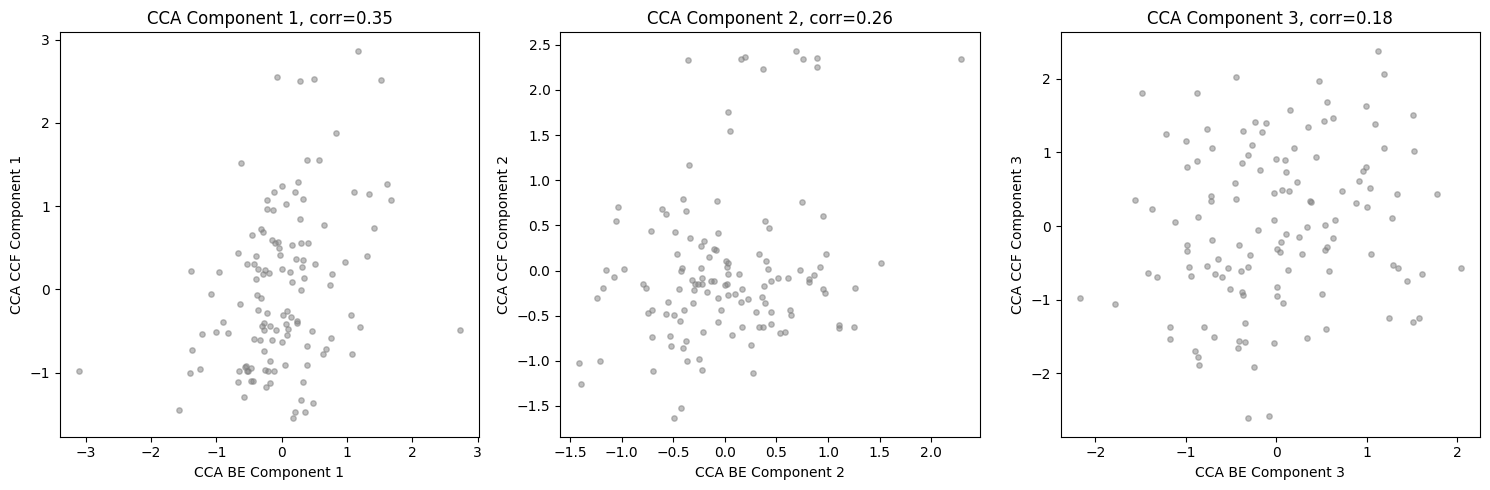

In [30]:
# cca in space
from sklearn.cross_decomposition import CCA
from scipy.stats import rankdata

ranked = False
focus_features_cca = focus_features
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = features_combined['be_filter'].values
cca_be_mat = features_combined[focus_features_cca].values[filter]

bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = -np.abs(ccf_mat[:, ml])  # Mirror ML to right


# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]
# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')
if ranked:
    ccf_mat = ccf_mat_ranked
# zscore
cca_be_mat = zscore(cca_be_mat, axis=0, nan_policy='omit')
# ccf_mat = zscore(ccf_mat, axis=0, nan_policy='omit')
cca = CCA(n_components=3)
cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)
# plot cca result
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    ax.scatter(cca_result_be[:, i], cca_result_ccf[:, i], c='gray', alpha=0.5, s=15)
    ax.set_xlabel(f'CCA BE Component {i+1}')
    ax.set_ylabel(f'CCA CCF Component {i+1}')
    ax.set_title(f'CCA Component {i+1}, corr={np.corrcoef(cca_result_be[:, i], cca_result_ccf[:, i])[0, 1]:.2f}')
# # print coefficients
# cca_be_coeff = cca.x_weights_
# for i in range(3):
#     print(f'CCA BE Component {i+1} Coefficients:')
#     for j, feature in enumerate(focus_features):
#         print(f'  {feature}: {cca_be_coeff[j, i]:.4f}')
# print cca ccf coeff
cca_ccf_coeff = cca.y_weights_
for i in range(3):
    print(f'CCA CCF Component {i+1} Coefficients:')
    for j, axis in enumerate(['x_ccf', 'y_ccf', 'z_ccf']):
        print(f'{axis}: {cca_ccf_coeff[j, i]:.4f}')

fig.tight_layout()
fig.savefig(os.path.join(target_folder, f'CCA_beh_CCF_scatter_ranked_{ranked}.pdf'), bbox_inches='tight')


In [ ]:
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cross_decomposition import CCA
from collections import defaultdict
alpha = 0.05
# ==========================================================
#   0. ORIGINAL CCA FIT
# ==========================================================
focus_features_cca = focus_features
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = features_combined['be_filter'].values
cca_be_mat = features_combined[focus_features_cca].values[filter]

bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = -np.abs(ccf_mat[:, ml])  # Mirror ML to left

# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]

# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')

if ranked:
    ccf_mat = ccf_mat_ranked

cca = CCA(n_components=2)
cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

xw = cca.x_weights_.copy()
yw = cca.y_weights_.copy()

n_samples = cca_be_mat.shape[0]
n_features_be = cca_be_mat.shape[1]

# normalized anatomical CCA vectors
cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)


# ==========================================================
#   1. BIN DATA INTO 3D VOXELS
# ==========================================================

coords = ccf_mat  # N×3 anatomical points

# choose bin counts
n_bins_xyz = (2, 3, 3)

bins = [
    np.linspace(coords[:, i].min()-0.1, coords[:, i].max()+0.1, n_bins_xyz[i] + 1)
    for i in range(3)
]

xbin = np.digitize(coords[:, 0], bins[0]) - 1
ybin = np.digitize(coords[:, 1], bins[1]) - 1
zbin = np.digitize(coords[:, 2], bins[2]) - 1

# voxel → sample indices
voxel_map = defaultdict(list)
for i in range(len(coords)):
    v = (xbin[i], ybin[i], zbin[i])
    voxel_map[v].append(i)

valid_voxels = [v for v in voxel_map if len(voxel_map[v]) > 0]

# number of points per voxel
counts = np.array([len(voxel_map[v]) for v in valid_voxels])
total_count = counts.sum()

# compute proportional sample counts per voxel
samples_per_voxel = np.maximum(
    1,  # ensure every voxel contributes
    np.floor((counts / total_count) * n_samples).astype(int)
)


# ==========================================================
#   2. BOOTSTRAP LOOP WITH PROPORTIONAL SAMPLING
# ==========================================================

n_boot = 1000
rng = np.random.default_rng(4)

boot_xw = np.zeros((n_boot, n_features_be, 2))
boot_yw = np.zeros((n_boot, 3, 2))

for b in range(n_boot):
    indices = []

    # sample proportionally from each voxel
    for vox_idx, voxel in enumerate(valid_voxels):
        n_draw = voxel_map[voxel].__len__()

        picked = rng.choice(
            voxel_map[voxel],
            size=n_draw,
            replace=True
        )
        indices.extend(picked)

    indices = np.array(indices)

    Xb = cca_be_mat[indices]
    Yb = ccf_mat[indices]

    cca_b = CCA(n_components=2)
    cca_b.fit(Xb, Yb)

    boot_xw[b] = cca_b.x_weights_
    boot_yw[b] = cca_b.y_weights_


# n_boot = 1000
# rng = np.random.default_rng(4)

# boot_xw = np.zeros((n_boot, n_features_be, 2))
# boot_yw = np.zeros((n_boot, 3, 2))

# for b in range(n_boot):
#     indices = []

#     # --- bootstrap sampling proportional to voxel size ---
#     for vox_idx, voxel in enumerate(valid_voxels):
#         n_draw = len(voxel_map[voxel])
#         picked = rng.choice(voxel_map[voxel], size=n_draw, replace=True)
#         indices.extend(picked)

#     indices = np.array(indices)

#     Xb = cca_be_mat[indices]
#     Yb = ccf_mat[indices]

#     # ====================================================
#     # 1️⃣ Fit first CCA component (normal)
#     # ====================================================
#     cca_b1 = CCA(n_components=1)
#     cca_b1.fit(Xb, Yb)

#     xw_1 = cca_b1.x_weights_[:, 0]
#     yw_1 = cca_b1.y_weights_[:, 0]

#     xw_1 /= np.linalg.norm(xw_1)
#     yw_1 /= np.linalg.norm(yw_1)

#     boot_xw[b, :, 0] = xw_1
#     boot_yw[b, :, 0] = yw_1

#     # ====================================================
#     # 2️⃣ Fit second component with fixed first axis
#     # ====================================================
#     # remove projections along the original fixed first axis
#     # (xw_ori, yw_ori are provided as fixed first-component weights)


#     # Normalize the first canonical axis only
#     xw_ori_1 = xw[:, 0]
#     yw_ori_1 = yw[:, 0]

#     xw_ori_1 = xw_ori_1 / np.linalg.norm(xw_ori_1)
#     yw_ori_1 = yw_ori_1 / np.linalg.norm(yw_ori_1)


#     Xb_res = Xb - (Xb @ xw_ori_1[:, None]) * xw_ori_1[None, :]
#     Yb_res = Yb - (Yb @ yw_ori_1[:, None]) * yw_ori_1[None, :]

#     # fit CCA on residuals for 2nd component
#     cca_b2 = CCA(n_components=1)
#     cca_b2.fit(Xb_res, Yb_res)

#     xw_2 = cca_b2.x_weights_[:, 0]
#     yw_2 = cca_b2.y_weights_[:, 0]

#     # xw_2 = xw_2 - np.dot(xw_2, xw_ori_1) * xw_ori_1
#     # yw_2 = yw_2 - np.dot(yw_2, yw_ori_1) * yw_ori_1

#     boot_xw[b, :, 1] = xw_2
#     boot_yw[b, :, 1] = yw_2


# ==========================================================
#  SIGN ALIGNMENT (recommended)
# ==========================================================

boot_yw_aligned = boot_yw.copy()
boot_xw_aligned = boot_xw.copy()

boot_yw_norm = (
    boot_yw_aligned /
    np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
)

for comp in range(2):
    ref = cca_vecs[:, comp]
    for b in range(n_boot):
        if np.dot(boot_yw_norm[b, :, comp], ref) < 0:
            boot_yw_aligned[b, :, comp] *= -1
            boot_xw_aligned[b, :, comp] *= -1




boot_yw = boot_yw_aligned.copy()
boot_xw = boot_xw_aligned.copy()
# compute CI bounds
xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)

yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

# ================================================================
#                   PRINT RESULTS WITH CI
# ================================================================
print("\n===== Behavior → CCA Weights (x_weights_) =====\n")
for comp in range(2):
    print(f"Component {comp+1}:")
    for j, feat in enumerate(focus_features_cca):
        mean_w = xw[j, comp]
        lo = xw_low[j, comp]
        hi = xw_high[j, comp]
        print(f"  {feat:20s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
    print()

print("\n===== CCF → CCA Weights (y_weights_) =====\n")
axes = ['x_ccf', 'y_ccf', 'z_ccf']
for comp in range(2):
    print(f"Component {comp+1}:")
    for j, axname in enumerate(axes):
        mean_w = cca_vecs[j, comp]
        lo = yw_low[j, comp]
        hi = yw_high[j, comp]
        print(f"  {axname:10s}  mean={mean_w:+.4f},  CI=({lo:+.4f}, {hi:+.4f})")
    print()

In [ ]:
# plot cca ccf components weight in space as vector in ccf space with mesh
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = -np.abs(ccf_mat[:, ml])  # Mirror ML to left
for plane_ind, plane in enumerate(planes.keys()):
    ax = axes[plane_ind]
    ax.scatter(mesh_vertices_lps[:, planes[plane][0]], mesh_vertices_lps[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
    for i in range(2):
        vec = cca_vecs[:, i]
        origin = np.nanmean(ccf_mat, axis=0)
        # origin = np.zeros(3)
        ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
                  vec[planes[plane][0]], vec[planes[plane][1]],
                  angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')
    ax.set_title(f'CCA CCF Components in {plane} plane')
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'CCA_CCF_components_in_space.pdf'), bbox_inches='tight')

In [ ]:
boot_yw_norm = boot_yw_aligned.copy()
# boot_yw_norm = boot_yw_aligned
origin = np.nanmean(mesh_vertices_lps, axis=0)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ----- Setup 3 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 18), width_ratios=[1.5, 1.1, 1])

# Extract and normalize CCA component vectors
# cca_vecs = cca_ccf_coeff.copy()
# cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

# Optional: mean of CCF as the origin
# origin = np.nanmean(ccf_mat, axis=0)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']

for comp in range(2):   # row index → component number
    for plane_ind, plane in enumerate(planes.keys()):  # column index → plane
        ax = axes[comp, plane_ind]

        ix, iy = planes[plane]

        # anatomical mesh
        # ax.scatter(
        #     mesh_vertices_lps[:, ix],
        #     mesh_vertices_lps[:, iy],
        #     color='lightgray',
        #     alpha=0.1,
        #     s=0.2
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
        #     vec[planes[plane][0]], vec[planes[plane][1]],
        #     angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))

        # ---------- BOOTSTRAP VECTOR CLOUD ----------
        for b in range(n_boot):
            vec = boot_yw_norm[b, :, comp]

            ax.quiver(
                origin[ix], origin[iy],
                vec[ix], vec[iy],
                angles='xy',
                scale_units='xy',
                scale=1/0.25,
                color=[0.5, 0.5, 0.5],
                alpha=0.3,      # transparent bootstrap vectors
                width=0.001,
                linewidth=0.01
            )

        # ---------- ORIGINAL CCA VECTOR (THICK) ----------
        vec0 = cca_vecs[:, comp]

        ax.quiver(
            origin[ix], origin[iy],
            vec0[ix], vec0[iy],
            angles='xy',
            scale_units='xy',
            scale=1/0.25,
            color=cm.viridis(comp / 3),
            width=0.003,
            linewidth=0.25,
            label=f'Comp {comp+1}'
        )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        # ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_3x3.pdf'),
    bbox_inches='tight'
)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ----- Convert vectors → spherical angles -----

# def vector_to_angles(v):
#     """Return (azimuth phi, elevation theta) for vector v."""
#     x, y, z = v
#     phi = np.arctan2(y, x)                     # horizontal angle
#     theta = np.arctan2(z, np.sqrt(x*x + y*y))  # vertical angle
#     return phi, theta


def vector_to_angles(v, off_set = 0.2):
    """Return (phi_new, theta) where φ=1 rad maps to φ_new=0."""
    x, y, z = v

    # raw azimuth φ in [0, 2π)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2 * np.pi

    # shift reference so φ=1 → φ_new=0
    phi_new = phi + off_set
    if phi_new < 0:
        phi_new += 2 * np.pi
    elif phi_new >= 2*np.pi:
        phi_new -= 2 * np.pi

    # elevation θ stays the same
    theta = np.arctan2(z, np.sqrt(x*x + y*y))

    return phi_new, theta

def express_in_basis(v, a):
    """
    Express vector v in a new coordinate system where:
      - z-axis is aligned with vector a
      - x- and y-axes are orthogonal to a (right-handed system)

    Returns:
        v_new : np.ndarray
            Coordinates of v in the new (x, y, z=a) basis
        R : np.ndarray
            3×3 rotation matrix (columns are the new basis vectors)
    """
    a = np.asarray(a, dtype=float)
    v = np.asarray(v, dtype=float)

    # Normalize z-axis (the reference direction)
    z_axis = a / np.linalg.norm(a)

    # Pick a stable arbitrary vector not parallel to z
    if abs(z_axis[0]) < 0.9:
        tmp = np.array([1, 0, 0])
    else:
        tmp = np.array([0, 1, 0])

    # Build x-axis orthogonal to z (Gram–Schmidt)
    x_axis = tmp - np.dot(tmp, z_axis) * z_axis
    x_axis /= np.linalg.norm(x_axis)

    # y-axis = z × x (right-handed system)
    y_axis = np.cross(z_axis, x_axis)
    y_axis /= np.linalg.norm(y_axis)

    # Rotation matrix: columns are new basis vectors
    R = np.column_stack([x_axis, y_axis, z_axis])

    # Express v in new basis
    v_new = R.T @ v

    return v_new, R

# Compute angles for bootstrap samples
phi_boot = np.zeros((n_boot, 2))
theta_boot = np.zeros((n_boot, 2))

# Compute angles for original CCA vectors
phi_orig = np.zeros(2)
theta_orig = np.zeros(2)
comp = 0
v0 = cca_vecs[:, comp]   # normalized
phi_orig[comp], theta_orig[comp] = vector_to_angles(v0, off_set=np.pi - np.arctan2(v0[1], v0[0]))
comp = 1
v1 = cca_vecs[:, comp]
v1_proj, R = express_in_basis(v1, cca_vecs[:, 0])
phi_orig[comp], theta_orig[comp] = vector_to_angles(v1_proj, off_set= -np.arctan2(v1_proj[1], v1_proj[0]) + np.pi)

# for component 0
comp = 0
for b in range(n_boot):
    v = boot_yw_norm[b, :, comp]
    phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v, off_set=np.pi - np.arctan2(v0[1], v0[0]))

# for component 1
comp = 1
for b in range(n_boot):
    v = boot_yw_norm[b, :, comp]
    # project v onto plane orthogonal to component 0
    v_proj, R = express_in_basis(v, cca_vecs[:, 0])
    # convert projected 2D vector to angles
    phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v_proj, off_set=-np.arctan2(v1_proj[1], v1_proj[0]) + np.pi)



# ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for comp in range(2):
    ax = axes[comp]
    
    ax.scatter(
        phi_boot[:, comp],
        theta_boot[:, comp],
        s=8, alpha=0.2,
        color=cm.viridis(comp/3)
    )
    
    # Plot original CCA direction
    ax.scatter(
        phi_orig[comp],
        theta_orig[comp],
        s=120, color='red', edgecolor='black', label='Original CCA'
    )

    ax.set_title(f'Component {comp+1}')
    ax.set_xlabel('Azimuth φ (radians)')
    ax.set_ylabel('Elevation θ (radians)')
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'CCA_direction_angle_scatter.pdf'),
            bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

def kth_percentile_contour_levels(values, kde, xx, yy, levels=[0.1, 0.3, 0.5, 0.9]):
    """
    Convert percentile levels into actual KDE contour threshold values.

    Parameters
    ----------
    values : ndarray
        Flattened KDE values (e.g., kde(np.vstack([xx.ravel(), yy.ravel()]))).
    kde : gaussian_kde
        KDE object (not used in computation, kept for compatibility).
    xx, yy : ndarray
        Meshgrid arrays corresponding to evaluation grid (not used directly).
    levels : list of float
        Percentiles as fractions of total probability mass (e.g. [0.1, 0.3, 0.5, 0.9]).

    Returns
    -------
    contour_levels : list of float
        Density thresholds corresponding to requested cumulative probabilities.
    """
    # Sort KDE density values in descending order
    sorted_vals = np.sort(values)[::-1]

    # Compute normalized cumulative sum
    cumsum = np.cumsum(sorted_vals)
    cumsum /= cumsum[-1]  # normalize to 1

    contour_levels = []
    for p in levels:
        # smallest density threshold such that area above it = p
        # use interpolation for smoother results
        idx = np.searchsorted(cumsum, p)
        if idx >= len(sorted_vals):
            idx = len(sorted_vals) - 1
        contour_levels.append(sorted_vals[idx])

    return contour_levels

# -----------------------------------------------------------
# φ–θ DENSITY CONTOUR PLOT (10%, 30%, 50%, 90%) + marginals
# -----------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for comp in range(2):
    ax = axes[comp]

    # KDE over φ–θ samples
    data = np.vstack([phi_boot[:, comp], theta_boot[:, comp]])
    kde = gaussian_kde(data, bw_method=0.3)

    # grid for density evaluation
    phi_grid = np.linspace(0, 2*np.pi, 300)
    theta_grid = np.linspace(-np.pi/2, np.pi/2, 300)
    xx, yy = np.meshgrid(phi_grid, theta_grid)
    zz = kde(np.vstack([xx.flatten(), yy.flatten()]))
    zz_grid = zz.reshape(xx.shape)

    # scatter bootstraps
    ax.scatter(phi_boot[:, comp], theta_boot[:, comp],
               s=8, alpha=0.2, color=cm.viridis(comp/3))

    # percentile contour levels
    contour_levels = kth_percentile_contour_levels(
        zz, kde, xx, yy, levels=[0.10, 0.30, 0.50, 0.90]
    )
    contour_levels_sorted = np.sort(contour_levels)

    # density background
    ax.imshow(
        zz_grid, origin='lower',
        extent=[0, 2*np.pi, -np.pi/2, np.pi/2],
        aspect='auto', cmap='Blues', alpha=0.3
    )

    # main contours
    cs = ax.contour(
        xx, yy, zz_grid,
        levels=contour_levels_sorted,
        colors=["black", "blue", "purple", "red"],
        linewidths=[1.5, 2.0, 2.5, 3.0]
    )
    fmt = {val: label for val, label in zip(contour_levels_sorted, ["10%", "30%", "50%", "90%"])}
    ax.clabel(cs, inline=True, fontsize=10, fmt=fmt)

    # original CCA direction
    ax.scatter(phi_orig[comp], theta_orig[comp],
               s=100, color='yellow', edgecolor='black', zorder=5,
               label="Original CCA direction")

    # axis settings
    if comp == 0:
        ax.set_title(f'Direction Distribution — Component {comp+1}-Relative to CCF')
    else:
        ax.set_title(f'Direction Distribution — Component {comp+1}-Relative to Comp 1')
    ax.set_xlabel("Azimuth φ (radians)")
    ax.set_ylabel("Elevation θ (radians)")
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.grid(True)
    ax.legend()

    # -------------------------------------------------------
    # MARGINAL HISTOGRAMS (top and right)
    # -------------------------------------------------------
    divider = make_axes_locatable(ax)
    ax_histx = divider.append_axes("top", size=1.0, pad=0.3, sharex=ax)
    ax_histy = divider.append_axes("right", size=1.0, pad=0.3, sharey=ax)

    # Hide tick labels on hist axes
    plt.setp(ax_histx.get_xticklabels(), visible=False)
    plt.setp(ax_histy.get_yticklabels(), visible=False)

    # Plot histograms
    ax_histx.hist(phi_boot[:, comp], bins=40, color='gray', alpha=0.7)
    ax_histy.hist(theta_boot[:, comp], bins=40, orientation='horizontal', color='gray', alpha=0.7)

    # Match limits
    ax_histx.set_xlim(ax.get_xlim())
    ax_histy.set_ylim(ax.get_ylim())

    # Simplify look
    for spine in ax_histx.spines.values():
        spine.set_visible(False)
    for spine in ax_histy.spines.values():
        spine.set_visible(False)

# plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_direction_angle_density_contours_with_marginals.pdf'),
    bbox_inches='tight'
)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normalize CCA vectors
cca_vecs = cca_ccf_coeff.copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
n_se = 3  # 1 standard error ellipse
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        # Collect bootstrap vectors for this component
        boot_vecs = boot_yw_norm[:, :, comp]
        # Mean vector
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # Project all bootstrap vectors to the plane (ix, iy)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        # Compute 2D covariance for cone/ellipse (bootstrapped spread)
        cov = np.cov(vecs_2d.T)

        # Convert covariance to *standard error* ellipse
        eigvals, eigvecs = np.linalg.eigh(cov / n_boot)  # divide by n_boot for SE

        # Scale by desired number of SEs (e.g., 1 → 1 SE, 2 → 95% CI)
        width, height = 2 * n_se * np.sqrt(eigvals)
        angle = np.degrees(np.arctan2(*eigvecs[:, 1][::-1]))

        scale = 1/0.25  # scaling factor for arrow length
        end_x = origin[ix] + mean_2d[0] / scale
        end_y = origin[iy] + mean_2d[1] / scale

        # Ellipse centered at arrow tip
        ellipse = Ellipse(
            xy=(end_x, end_y),
            width=width, height=height, angle=angle,
            edgecolor=cm.viridis(comp / 3),
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)

        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.004, linewidth=1.0,
            label=f'Comp {comp+1}'
        )

        # ----------------------------
        # OPTIONAL: TRUE CCA VECTOR
        # ----------------------------
        # true_vec = cca_vecs[:, comp]
        # ax.quiver(
        #     origin[ix], origin[iy],
        #     true_vec[ix], true_vec[iy],
        #     angles='xy', scale_units='xy', scale=1/0.25,
        #     color='black', width=0.002, linewidth=0.5,
        #     alpha=0.8, label='Original CCA'
        # )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_SE_cones.pdf'),
    bbox_inches='tight'
)
plt.show()


In [ ]:
# plot contribution of each feature to cca components as bar plots
cca_be_coeff = cca.x_weights_
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    ax = axes[i]
    ax.bar(focus_features_cca, cca_be_coeff[:, i], color='gray', alpha=0.7)
    ax.set_title(f'CCA BE Component {i+1} Loadings')
    ax.set_ylabel('Loading Value')
    ax.set_xticklabels(focus_features_cca, rotation=45, ha='right')
fig.tight_layout()
fig.savefig(os.path.join(target_folder, 'CCA_beh_components_loadings.pdf'), bbox_inches='tight')
    

In [ ]:
custom_cmap_1 = LinearSegmentedColormap.from_list(
    "black_red",
    [(0, 0, 0), (1, 0, 0)]
)
custom_cmap_0 = LinearSegmentedColormap.from_list(
    "cool_warm",
    [(0, 1, 1), (1, 0, 1)]
)
custom_cmap_2 = LinearSegmentedColormap.from_list(
    "blue_yellow",
    [(0, 0, 1), (1, 1, 0)]
)

custom_cmaps = [custom_cmap_0, custom_cmap_1, custom_cmap_2]

In [ ]:
# plot cca be features in ccf space as color code
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter][~nan_ind_cca]
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # Mirror ML to left
for dim_ind in range(2):
    cca_values = cca_result_be[:, dim_ind]
    # clip to 2.5-97.5 percentile
    top_90 = np.nanquantile(cca_values, 0.95)
    bottom_10 = np.nanquantile(cca_values, 0.05)
    cca_values_nl = np.clip(cca_values, bottom_10, top_90)
    cca_values_nl = (cca_values_nl - bottom_10) / (top_90 - bottom_10)
    cca_values_nl[np.isnan(cca_values_nl)] = 0.0
    # change to rank
    cca_values_nl = rankdata(cca_values_nl) / len(cca_values_nl)

    for j, plane in enumerate(planes.keys()):
        ax = axes[dim_ind, j]
        ax.scatter(mesh_vertices_lps[:, planes[plane][0]], mesh_vertices_lps[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
        sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=cca_values_nl, cmap=custom_cmaps[dim_ind], s=110, edgecolor='none', alpha=0.4)
        if plane == 'hor':
            ax.set_title(f'CCA BE Comp {dim_ind+1}')
        vec = cca_ccf_coeff[:, dim_ind]
        origin = np.nanmean(ccfs, axis=0)
        # origin = np.zeros(3)
        ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
                  vec[planes[plane][0]], vec[planes[plane][1]],
                  angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {dim_ind+1}', color='r')
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'CCA_beh_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

In [ ]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# --- create figure with 3 rows (CCA components) and one column per feature ---
fig, axes = plt.subplots(2, len(focus_features_cca), figsize=(5*len(focus_features_cca), 12))

for j in range(2):  # iterate over CCA components
    cca_ccf_values = cca_result_ccf[:, j]
    all_p = []
    all_coef = []
    for i, feature in enumerate(focus_features_cca):
        ax = axes[j, i]
        feature_values = features_combined[feature].values[filter][~nan_ind_cca]

        # scatter plot
        ax.scatter(feature_values, cca_ccf_values, c='gray', alpha=0.5, s=30)
        ax.set_xlabel(feature)
        if i == 0:
            ax.set_ylabel(f'CCA CCF Comp {j+1}')

        # compute correlation
        corr_coef, p_value = pearsonr(feature_values, cca_ccf_values)
        all_p.append(p_value)
        all_coef.append(corr_coef)

    # adjust for multiple comparisons 
    reject, pvals_corrected, _, _ = multipletests(all_p, method='fdr_bh', alpha=0.05)
    for i, ax in enumerate(axes[j, :]):
        if reject[i]:
            ax.set_title(f'Sig (r={all_coef[i]:.2f}, p_corrected={pvals_corrected[i]:.3f})', color='red')
        else:
            ax.set_title(f'Not Sig (r={all_coef[i]:.2f}, p_corrected={pvals_corrected[i]:.3f})', color='black')



plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_beh_CCF_scatter_by_component.pdf'),
    bbox_inches='tight', dpi=300
)
plt.show()

##  Shuffling

In [ ]:
# create a functions that takes in cca_be_mat and ccf_mat and performs the entire cca with bootstrap and returns the cca results with ci
# outputs: cca_result_be, cca_result_ccf, xw_low, xw_high, yw_low, yw_high, boot_xw, boot_yw, cca_x_weights, cca_y_weights
from sklearn.cross_decomposition import CCA
import numpy as np
from collections import defaultdict
def perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05, return_all=False):
    # Fit original CCA
    cca = CCA(n_components=2)
    cca.fit(cca_be_mat, ccf_mat)
    xw = cca.x_weights_
    yw = cca.y_weights_

    cca_result_be, cca_result_ccf = cca.fit_transform(cca_be_mat, ccf_mat)

    cca_vecs = yw / np.linalg.norm(yw, axis=0, keepdims=True)

    # Bin data into 3D voxels
    coords = ccf_mat
    n_bins_xyz = (3, 3, 4)
    bins = [
        np.linspace(coords[:, i].min()-0.1, coords[:, i].max()+0.1, n_bins_xyz[i] + 1)
        for i in range(3)
    ]
    xbin = np.digitize(coords[:, 0], bins[0]) - 1
    ybin = np.digitize(coords[:, 1], bins[1]) - 1
    zbin = np.digitize(coords[:, 2], bins[2]) - 1

    voxel_map = defaultdict(list)
    for i in range(len(coords)):
        v = (xbin[i], ybin[i], zbin[i])
        voxel_map[v].append(i)

    valid_voxels = [v for v in voxel_map if len(voxel_map[v]) > 0]
    counts = np.array([len(voxel_map[v]) for v in valid_voxels])
    total_count = counts.sum()
    samples_per_voxel = np.maximum(1, np.floor((counts / total_count) * n_samples).astype(int))

    # Bootstrap loop
    rng = np.random.default_rng(4)
    boot_xw = np.zeros((n_boot, cca_be_mat.shape[1], 2))
    boot_yw = np.zeros((n_boot, 3, 2))

    for b in range(n_boot):
        indices = []
        for vox_idx, voxel in enumerate(valid_voxels):
            n_draw = voxel_map[voxel].__len__()
            picked = rng.choice(
                voxel_map[voxel],
                size=n_draw,
                replace=True
            )
            indices.extend(picked)
        indices = np.array(indices)
        Xb = cca_be_mat[indices]
        Yb = ccf_mat[indices]
        cca_b = CCA(n_components=2)
        cca_b.fit(Xb, Yb)
        boot_xw[b] = cca_b.x_weights_
        boot_yw[b] = cca_b.y_weights_
        # for comp in range(2):
        #     xw = cca_b.x_weights_[:, comp]
        #     yw = cca_b.y_weights_[:, comp]
        #     xw /= np.linalg.norm(xw)
        #     yw /= np.linalg.norm(yw)
        #     boot_xw[b, :, comp] = xw
        #     boot_yw[b, :, comp] = yw
        # xw = cca_b.x_weights_[:, 0]
        # yw = cca_b.y_weights_[:, 0]
        # xw /= np.linalg.norm(xw)
        # yw /= np.linalg.norm(yw)
        # boot_xw[b, :, 0] = xw
        # boot_yw[b, :, 0] = yw
        # # # second component (optional)
        # xw = cca_b.x_weights_[:, 1]
        # yw = cca_b.y_weights_[:, 1]
        # xw /= np.linalg.norm(xw)
        # yw /= np.linalg.norm(yw)
        # boot_xw[b, :, 1] = xw
        # boot_yw[b, :, 1] = yw
        # Xb_res = Xb - (Xb @ xw[:, 0][:, None]) * xw[:, 0][None, :]
        # Yb_res = Yb - (Yb @ yw[:, 0][:, None]) * yw[:, 0][None, :]
        # cca_b2 = CCA(n_components=1)
        # cca_b2.fit(Xb_res, Yb_res)
        # xw_2 = cca_b2.x_weights_[:, 0]
        # yw_2 = cca_b2.y_weights_[:, 0]
        # boot_xw[b, :, 1] = xw_2
        # boot_yw[b, :, 1] = yw_2
    # Sign alignment
    boot_yw_aligned = boot_yw.copy()
    boot_xw_aligned = boot_xw.copy()

    boot_yw_norm = (
        boot_yw_aligned /
        np.linalg.norm(boot_yw_aligned, axis=1, keepdims=True)
    )

    for comp in range(2):
        ref = cca_vecs[:, comp]
        for b in range(n_boot):
            if np.dot(boot_yw_norm[b, :, comp], ref) < 0:
                boot_yw_aligned[b, :, comp] *= -1
                boot_xw_aligned[b, :, comp] *= -1




    boot_yw = boot_yw_aligned
    boot_xw = boot_xw_aligned

    boot_yw = (
        boot_yw /
        np.linalg.norm(boot_yw, axis=1, keepdims=True)
    )

    # compute CI bounds
    xw_low  = np.percentile(boot_xw, 100 * alpha/2, axis=0)
    xw_high = np.percentile(boot_xw, 100 * (1 - alpha/2), axis=0)
    yw_low  = np.percentile(boot_yw, 100 * alpha/2, axis=0)
    yw_high = np.percentile(boot_yw, 100 * (1 - alpha/2), axis=0)

    # save correlation of cca results
    corrs = np.corrcoef(cca_result_be.T, cca_result_ccf.T)
    corrs = np.diag(corrs[:2, 2:])

    # Compute angles 
    phi_boot = np.zeros((n_boot, 2))
    theta_boot = np.zeros((n_boot, 2))
    # mean vector
    v_mean = np.nanmean(boot_yw, axis=0)
    ang_mean_0 = np.arctan2(v_mean[1, 0], v_mean[0, 0])
    # ang_mean_1 = np.arctan2(v_mean[1, 1], v_mean[0, 1])
    # for comp 0
    comp = 0
    for b in range(n_boot):
        v = boot_yw[b, :, comp]
        phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v, off_set=np.pi-ang_mean_0)
    # for comp 1
    comp = 1
    v_proj = np.zeros((n_boot, 3))
    for b in range(n_boot):
        # project v onto plane orthogonal to component 0
        v_proj[b, :], R = express_in_basis(boot_yw[b, :, comp], cca_vecs[:, 0])
        # convert projected 2D vector to angles
    # mean vector
    v_mean_1 = np.nanmean(v_proj, axis=0)
    ang_mean_1 = np.arctan2(v_mean_1[1], v_mean_1[0])
    for b in range(n_boot):
        phi_boot[b, comp], theta_boot[b, comp] = vector_to_angles(v_proj[b, :], off_set=np.pi - ang_mean_1)

    # compute angles for original CCA vectors
    phi_orig = np.zeros(2)
    theta_orig = np.zeros(2)
    # for comp 0
    comp = 0
    v0 = cca_vecs[:, comp]   # normalized
    phi_orig[comp], theta_orig[comp] = vector_to_angles(v0, off_set=-0.5)
    # for comp 1
    comp = 1
    v1 = cca_vecs[:, comp]
    v1_proj, R = express_in_basis(v1, cca_vecs[:, 0])
    phi_orig[comp], theta_orig[comp] = vector_to_angles(v1_proj, off_set=1)


    # variance for directions:
    cov_matrix_comp0 = np.cov((boot_yw[:, :, 0]).T)
    cov_matrix_comp1 = np.cov((boot_yw[:, :, 1]).T)
    # eigen decomposition
    eigvals_vec_0, eigvecs_vec_0 = np.linalg.eig(cov_matrix_comp0)
    max_idx0 = np.argmax(eigvals_vec_0)
    principal_dir0_vec = eigvecs_vec_0[:, max_idx0]
    principal_var0_vec = eigvals_vec_0[max_idx0]

    eigvals_vec_1, eigvecs_vec_1 = np.linalg.eig(cov_matrix_comp1)
    max_idx1 = np.argmax(eigvals_vec_1)
    principal_dir1_vec = eigvecs_vec_1[:, max_idx1]
    principal_var1_vec = eigvals_vec_1[max_idx1]

    # variance for angles:
    # calcuate covariance of phi and theta
    cov_matrix_comp0 = np.cov(theta_boot[:, 0], phi_boot[:, 0])
    cov_matrix_comp1 = np.cov(theta_boot[:, 1], phi_boot[:, 1])
    # eigen decomposition
    # For component 0
    eigvals_ang_0, eigvecs_ang_0 = np.linalg.eig(cov_matrix_comp0)
    max_idx0 = np.argmax(eigvals_ang_0)
    principal_dir0_ang = eigvecs_ang_0[:, max_idx0]
    principal_var0_ang = eigvals_ang_0[max_idx0]

    # For component 1
    eigvals_ang_1, eigvecs_ang_1 = np.linalg.eig(cov_matrix_comp1)
    max_idx1 = np.argmax(eigvals_ang_1)
    principal_dir1_ang = eigvecs_ang_1[:, max_idx1]
    principal_var1_ang = eigvals_ang_1[max_idx1]
    result = {'corrs': corrs,
                # 'cca_result_be': cca_result_be,
                # 'cca_result_ccf': cca_result_ccf,
                # 'xw_low': xw_low,
                # 'xw_high': xw_high,
                # 'yw_low': yw_low,
                # 'yw_high': yw_high,
                # 'boot_xw': boot_xw,
                # 'boot_yw': boot_yw,
                'cca_x_weights': cca.x_weights_,
                'cca_y_weights': cca.y_weights_,
                'cca_vecs': cca_vecs,
                # 'phi_boot': phi_boot,
                # 'theta_boot': theta_boot,
                'phi_orig': phi_orig,
                'theta_orig': theta_orig,
                # 'var_phi': var_phi,
                # 'var_theta': var_theta,
                'eigvals_vec_0': np.sort(eigvals_vec_0)[::-1],
                # 'eigvecs_vec_0': eigvecs_vec_0,
                'eigvals_vec_1': np.sort(eigvals_vec_1)[::-1], 
                # 'eigvecs_vec_1': eigvecs_vec_1,
                'eigvals_ang_0': np.sort(eigvals_ang_0)[::-1],
                # 'eigvecs_ang_0': eigvecs_ang_0,
                'eigvals_ang_1': np.sort(eigvals_ang_1)[::-1],
                # 'eigvecs_ang_1': eigvecs_ang_1,
                }
    if not return_all:
        return result
    else:
        result.update({
            'boot_xw': boot_xw,
            'boot_yw': boot_yw,
            'phi_boot': phi_boot,
            'theta_boot': theta_boot,
        })
        return result
        
        
def shuffle_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05):
    # shuffle the cca_be_mat
    shuffled_cca_be_mat = cca_be_mat.copy()
    np.random.shuffle(shuffled_cca_be_mat)
    # perform cca with bootstrap
    results = perform_cca_with_bootstrap(shuffled_cca_be_mat, ccf_mat, n_samples, n_boot, alpha, return_all=False)
    return results

In [ ]:
focus_features_cca = focus_features
# focus_features_cca = focus_features+['beh_umap_1', 'beh_umap_2']
filter = features_combined['be_filter'].values
cca_be_mat = features_combined[focus_features_cca].values[filter]

bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])
ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
ccf_mat = ccf_mat - bregma_LPS_mm
ccf_mat[:, ml] = -np.abs(ccf_mat[:, ml])  # Mirror ML to left

# remove nan
nan_ind_cca = np.isnan(cca_be_mat).any(axis=1) | np.isnan(ccf_mat).any(axis=1)
cca_be_mat = cca_be_mat[~nan_ind_cca]
ccf_mat = ccf_mat[~nan_ind_cca]

# Convert to ranked values column-wise
ccf_mat_ranked = np.zeros_like(ccf_mat)
for i in range(ccf_mat.shape[1]):
    ccf_mat_ranked[:, i] = rankdata(ccf_mat[:, i], method='average')
if ranked:
    ccf_mat = ccf_mat_ranked
# zscore
cca_be_mat = zscore(cca_be_mat, axis=0, nan_policy='omit')
# ccf_mat = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter][~nan_ind_cca]
result_ori = perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=ccf_mat.shape[0], n_boot=1500, alpha=0.05, return_all=True)
# result = shuffle_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=1000, n_boot=1000, alpha=0.05)

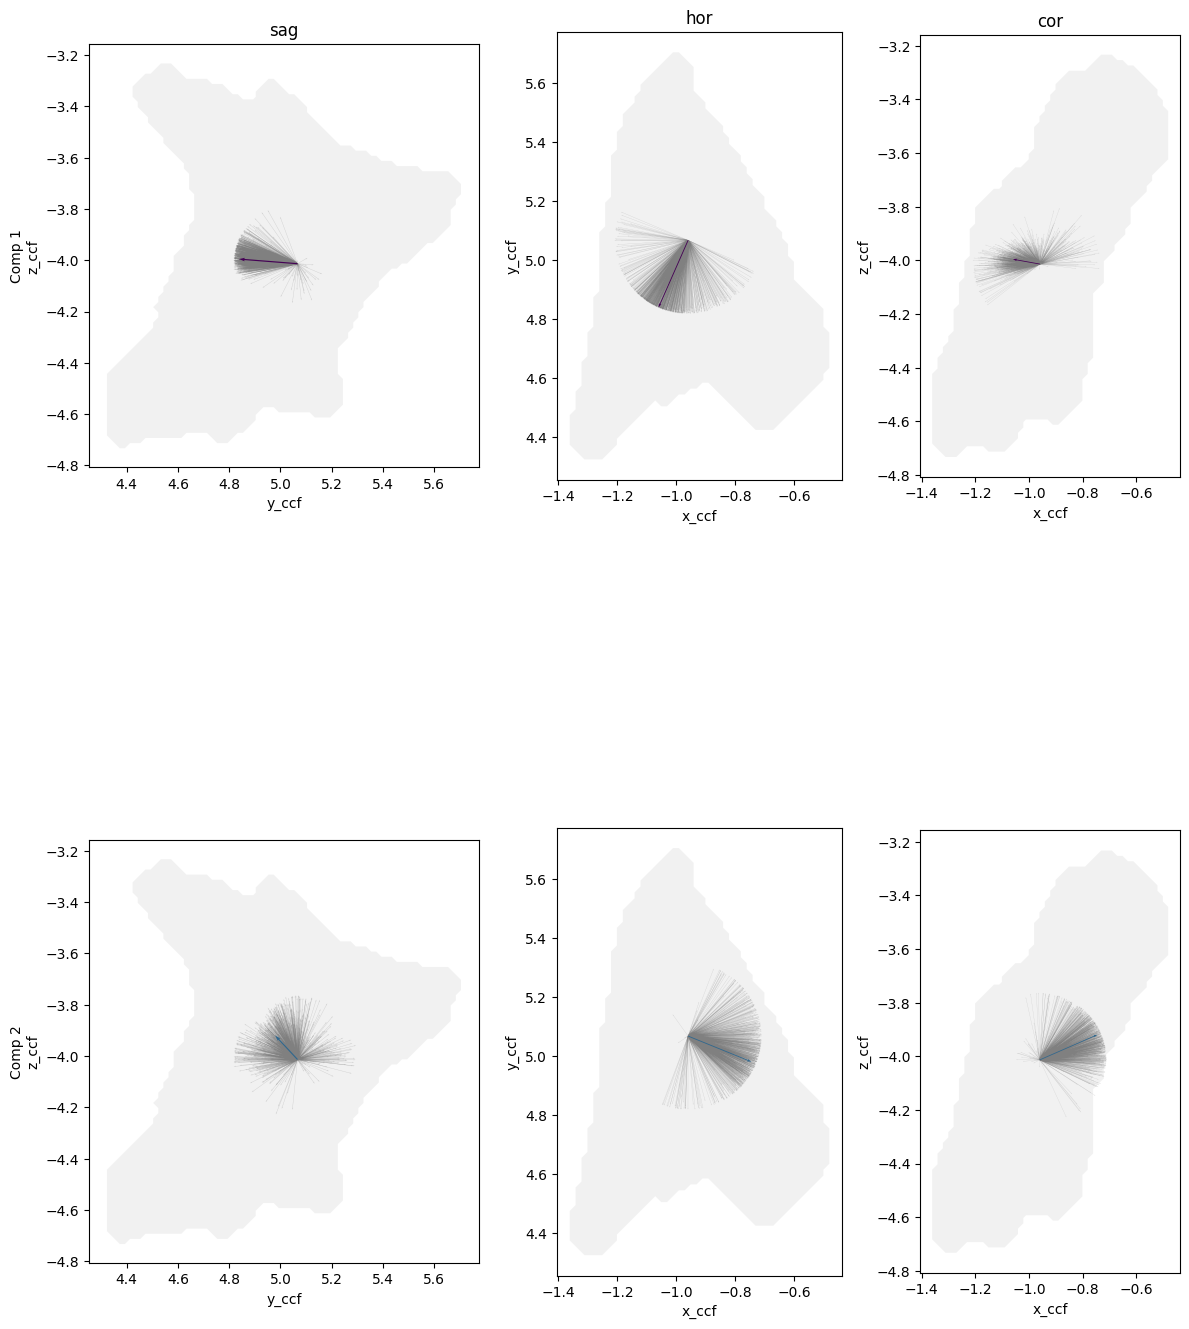

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# ----- Setup 3 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 18), width_ratios=[1.5, 1.1, 1])

# Extract and normalize CCA component vectors
cca_vecs = result_ori['cca_y_weights'].copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

# Optional: mean of CCF as the origin
# origin = np.nanmean(ccf_mat, axis=0)

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']

for comp in range(2):   # row index → component number
    for plane_ind, plane in enumerate(planes.keys()):  # column index → plane
        ax = axes[comp, plane_ind]

        ix, iy = planes[plane]

        # anatomical mesh
        # ax.scatter(
        #     mesh_vertices_lps[:, ix],
        #     mesh_vertices_lps[:, iy],
        #     color='lightgray',
        #     alpha=0.1,
        #     s=0.2
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ax.quiver(origin[planes[plane][0]], origin[planes[plane][1]],
        #     vec[planes[plane][0]], vec[planes[plane][1]],
        #     angles='xy', scale_units='xy', scale=3, label=f'CCA CCF Comp {i+1}', color=cm.viridis(i/3))

        # ---------- BOOTSTRAP VECTOR CLOUD ----------
        for b in range(n_boot):
            vec = result_ori['boot_yw'][b, :, comp]

            ax.quiver(
                origin[ix], origin[iy],
                vec[ix], vec[iy],
                angles='xy',
                scale_units='xy',
                scale=1/0.25,
                color=[0.5, 0.5, 0.5],
                alpha=0.3,      # transparent bootstrap vectors
                width=0.001,
                linewidth=0.01
            )

        # ---------- ORIGINAL CCA VECTOR (THICK) ----------
        vec0 = cca_vecs[:, comp]

        ax.quiver(
            origin[ix], origin[iy],
            vec0[ix], vec0[iy],
            angles='xy',
            scale_units='xy',
            scale=1/0.25,
            color=cm.viridis(comp / 3),
            width=0.003,
            linewidth=0.25,
            label=f'Comp {comp+1}'
        )

        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        # ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap_3x3.pdf'),
    bbox_inches='tight'
)
plt.show()


In [ ]:
from joblib import Parallel, delayed
parallel_results = Parallel(n_jobs=10)(
    delayed(shuffle_cca_with_bootstrap)(cca_be_mat, ccf_mat, n_samples=ccf_mat.shape[0], n_boot=1500, alpha=0.05)
    for _ in range(500)
)

/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warn

In [ ]:
# make results into df
shuffle_eigvals_vec_0 = np.array([res['eigvals_vec_0'] for res in parallel_results])
shuffle_eigvals_vec_1 = np.array([res['eigvals_vec_1'] for res in parallel_results])
shuffle_eigvals_ang_0 = np.array([res['eigvals_ang_0'] for res in parallel_results])
shuffle_eigvals_ang_1 = np.array([res['eigvals_ang_1'] for res in parallel_results])
shuffle_corr_0 = np.array([res['corrs'][0] for res in parallel_results])
shuffle_corr_1 = np.array([res['corrs'][1] for res in parallel_results])
import pandas as pd
shuffle_results_df = pd.DataFrame({
    'eigvals_vec_0_1': shuffle_eigvals_vec_0[:, 0],
    'eigvals_vec_0_2': shuffle_eigvals_vec_0[:, 1],
    'eigvals_vec_1_1': shuffle_eigvals_vec_1[:, 0],
    'eigvals_vec_1_2': shuffle_eigvals_vec_1[:, 1],
    'eigvals_ang_0_1': shuffle_eigvals_ang_0[:, 0],
    'eigvals_ang_0_2': shuffle_eigvals_ang_0[:, 1],
    'eigvals_ang_1_1': shuffle_eigvals_ang_1[:, 0],
    'eigvals_ang_1_2': shuffle_eigvals_ang_1[:, 1],
    'corr_0': shuffle_corr_0,
    'corr_1': shuffle_corr_1
})


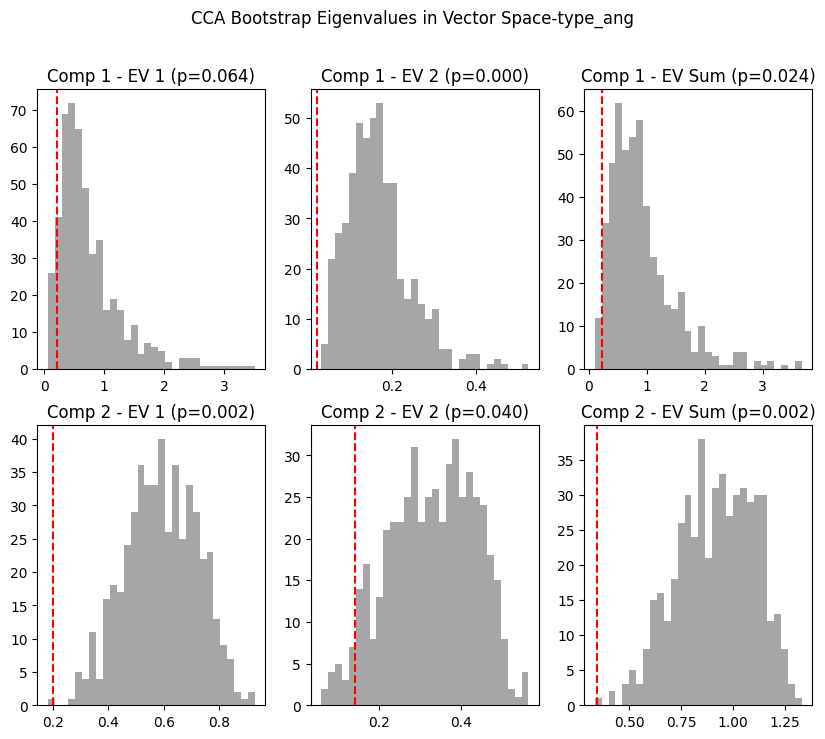

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
# Plot eigenvalue distributions for vector space
type = 'ang'
for comp in range(2):
    for eigen_int in range(2):
        ax = axes[comp, eigen_int]
        ax.hist(
            shuffle_results_df[f'eigvals_{type}_{comp}_{eigen_int+1}'],
            bins=30, color='gray', alpha=0.7
        )
        ax.axvline(
            x=result_ori[f'eigvals_{type}_{comp}'][eigen_int],
            color='red', linestyle='--',
            label='Original CCA'
        )
        p_value = np.mean(
            shuffle_results_df[f'eigvals_{type}_{comp}_{eigen_int+1}'] <=
            result_ori[f'eigvals_{type}_{comp}'][eigen_int]
        )
        ax.set_title(f'Comp {comp+1} - EV {eigen_int+1} (p={p_value:.3f})')
    eigen_sum = result_ori[f'eigvals_{type}_{comp}'].sum()
    eigen_sum_shuffle = shuffle_results_df[[f'eigvals_{type}_{comp}_1', f'eigvals_{type}_{comp}_2']].sum(axis=1)
    p_value = np.mean(eigen_sum_shuffle <= eigen_sum)
    axes[comp, 2].hist(
        eigen_sum_shuffle,
        bins=30, color='gray', alpha=0.7
    )
    axes[comp, 2].axvline(
        x=eigen_sum,
        color='red', linestyle='--',
        label='Original CCA'
    )
    axes[comp, 2].set_title(f'Comp {comp+1} - EV Sum (p={p_value:.3f})')
plt.suptitle(f'CCA Bootstrap Eigenvalues in Vector Space-type_{type}')
# plt.sca(axes[0, 0])
plt.savefig(
    os.path.join(target_folder, f'CCA_shuffle_variance_by_eigenvalues_{type}.pdf'),
    bbox_inches='tight'
)

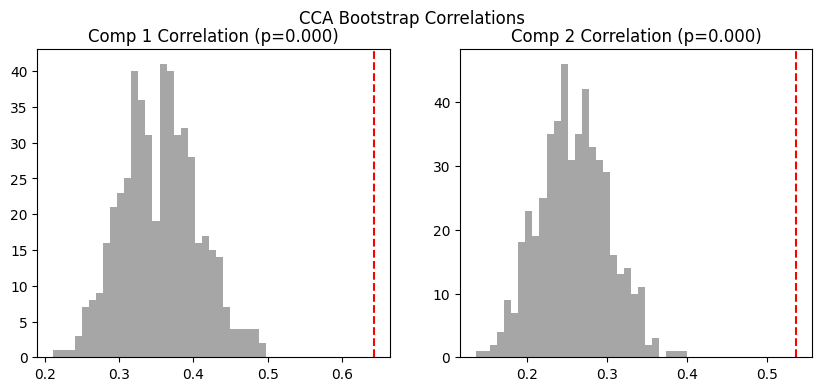

In [ ]:
# plot the same for corr
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for comp in range(2):
    ax = axes[comp]
    ax.hist(
        shuffle_results_df[f'corr_{comp}'],
        bins=30, color='gray', alpha=0.7
    )
    ax.axvline(
        x=result_ori['corrs'][comp],
        color='red', linestyle='--',
        label='Original CCA'
    )
    p_value = np.mean(
        shuffle_results_df[f'corr_{comp}'] >=
        result_ori['corrs'][comp]
    )
    ax.set_title(f'Comp {comp+1} Correlation (p={p_value:.3f})')
plt.suptitle(f'CCA Bootstrap Correlations')
plt.savefig(
    os.path.join(target_folder, f'CCA_shuffle_correlation.pdf'),
    bbox_inches='tight'
)

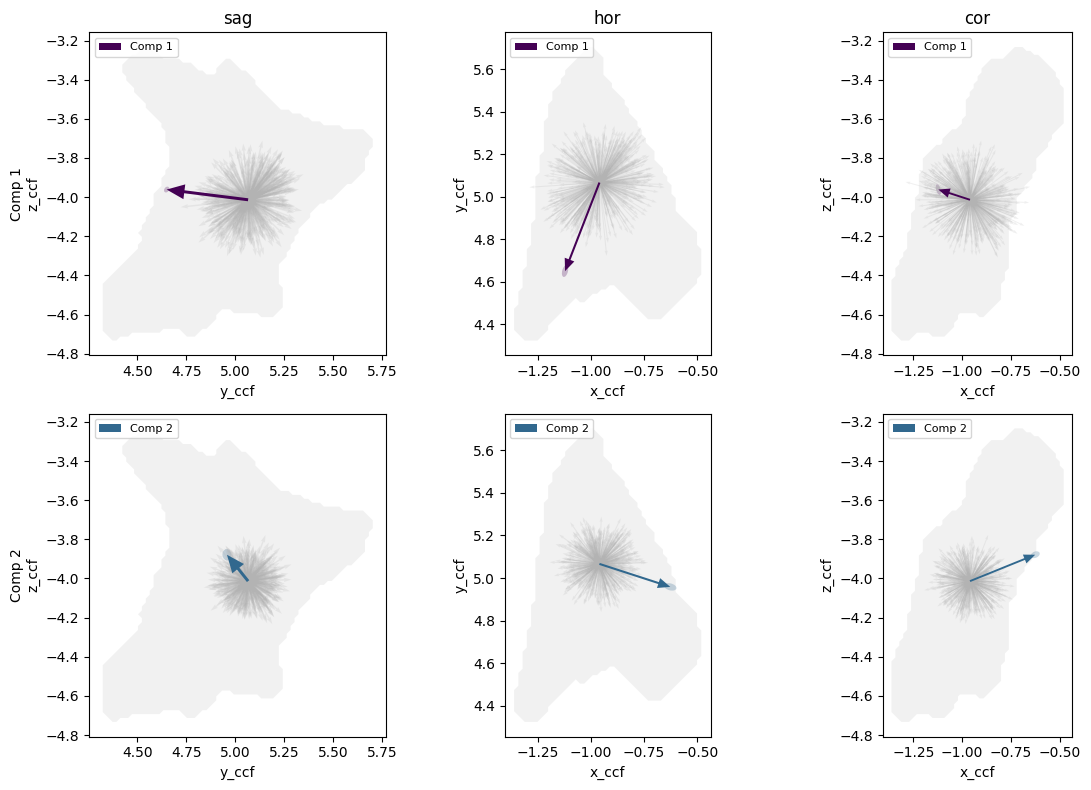

In [ ]:
# plot shuffled cca vectors in 2D planes with cones
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Ellipse

# ----- Setup 2 x 3 figure -----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normalize CCA vectors
cca_vecs = result_ori['cca_y_weights'].copy()
cca_vecs = cca_vecs / np.linalg.norm(cca_vecs, axis=0, keepdims=True)

boot_yw = result_ori['boot_yw']
boot_yw = boot_yw / np.linalg.norm(boot_yw, axis=1, keepdims=True)

n_boot = boot_yw.shape[0]

axis_labels = ['x_ccf', 'y_ccf', 'z_ccf']
n_se = 3  # 1 standard error ellipse
for comp in range(2):   # rows
    for plane_ind, plane in enumerate(planes.keys()):  # columns
        ax = axes[comp, plane_ind]
        ix, iy = planes[plane]

        # Draw anatomical background
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # ----------------------------
        # BOOTSTRAP VECTOR VARIABILITY
        # ----------------------------
        # Collect bootstrap vectors for this component
        boot_vecs = boot_yw[:, :, comp]
        # Mean vector
        mean_vec = np.nanmean(boot_vecs, axis=0)
        mean_vec /= np.linalg.norm(mean_vec)

        # Project all bootstrap vectors to the plane (ix, iy)
        vecs_2d = boot_vecs[:, [ix, iy]]
        mean_2d = mean_vec[[ix, iy]]

        # Compute 2D covariance for cone/ellipse (bootstrapped spread)
        cov = np.cov(vecs_2d.T)

        # Convert covariance to *standard error* ellipse
        eigvals, eigvecs = np.linalg.eigh(cov / n_boot)  # divide by n_boot for SE

        # Scale by desired number of SEs (e.g., 1 → 1 SE, 2 → 95% CI)
        width, height = 2 * n_se * np.sqrt(eigvals)
        angle = np.degrees(np.arctan2(*eigvecs[:, 1][::-1]))

        scale = (1/result_ori['corrs'][comp])*1/0.7  # scaling factor for arrow length
        end_x = origin[ix] + mean_2d[0] / scale
        end_y = origin[iy] + mean_2d[1] / scale

        # Ellipse centered at arrow tip
        ellipse = Ellipse(
            xy=(end_x, end_y),
            width=width, height=height, angle=angle,
            edgecolor=None,
            facecolor=cm.viridis(comp / 3),
            alpha=0.25, lw=1.2
        )
        ax.add_patch(ellipse)



        # ----------------------------
        # All shuffle vectors (transparent)
        # ----------------------------
        for shu in parallel_results:
            shu_vec = shu['cca_y_weights'][:, comp]
            shu_vec /= np.linalg.norm(shu_vec)
            scale = (1/(shu['corrs'][comp]))*1/0.7
            ax.quiver(
                origin[ix], origin[iy],
                shu_vec[ix], shu_vec[iy],
                angles='xy', scale_units='xy', scale=scale,
                color=[0.7, 0.7, 0.7],
                alpha=0.2,
                width=0.005,
                linewidth=0.01
            )
        # ----------------------------
        # MEAN VECTOR (CENTRAL AXIS)
        # ----------------------------
        scale = (1/result_ori['corrs'][comp])*1/0.7  # scaling factor for arrow length
        ax.quiver(
            origin[ix], origin[iy],
            mean_2d[0], mean_2d[1],
            angles='xy', scale_units='xy', scale=scale,
            color=cm.viridis(comp / 3),
            width=0.01,            # ⬅️ thicker arrow shaft (was 0.004)
            linewidth=1.5,         # ⬅️ slightly heavier outline
            headwidth=5,          # ⬅️ makes arrowhead wider
            headlength=6,         # ⬅️ makes arrowhead longer
            headaxislength=6,     # ⬅️ makes axis-aligned portion of head larger
            label=f'Comp {comp+1}'
        )


        # labels & style
        ax.set_xlabel(axis_labels[ix])
        ax.set_ylabel(axis_labels[iy])
        ax.set_aspect('equal')

        if comp == 0:
            ax.set_title(f'{plane}')

        if plane_ind == 0:
            ax.set_ylabel(f'Comp {comp+1}\n{axis_labels[iy]}')

        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(
    os.path.join(target_folder, 'CCA_CCF_components_bootstrap&shuffle_SE_cones.pdf'),
    bbox_inches='tight'
)
plt.show()


In [ ]:
results = perform_cca_with_bootstrap(cca_be_mat, ccf_mat, n_samples=5000, n_boot=1000, alpha=0.05)

# Compare with waveform features

In [ ]:
features_beh = ['T_response_svs_hit', 'T_outcome_com_mc', 'T_outcome_l_mc', 'T_outcome_e_mc', 'T_baseline_hit_all', 'T_response_hit_all',
                    'theta_com', 'theta_l', 'theta_e', 'coef_outcome|(|coef_outcome| + |coef_Q|)']

In [ ]:
features_wf = wf_features.columns.to_list()
features_wf.remove('session')
features_wf.remove('unit_id')
features_wf.remove('wf')
# features_wf.remove('gmm_label')
# features_wf.remove('kmeans_label')
# features_wf.remove('gmm_conf')
features_wf.remove('y_loc')
# features_wf.remove('probe')
features_wf.remove('peak')
features_wf.remove('amp')

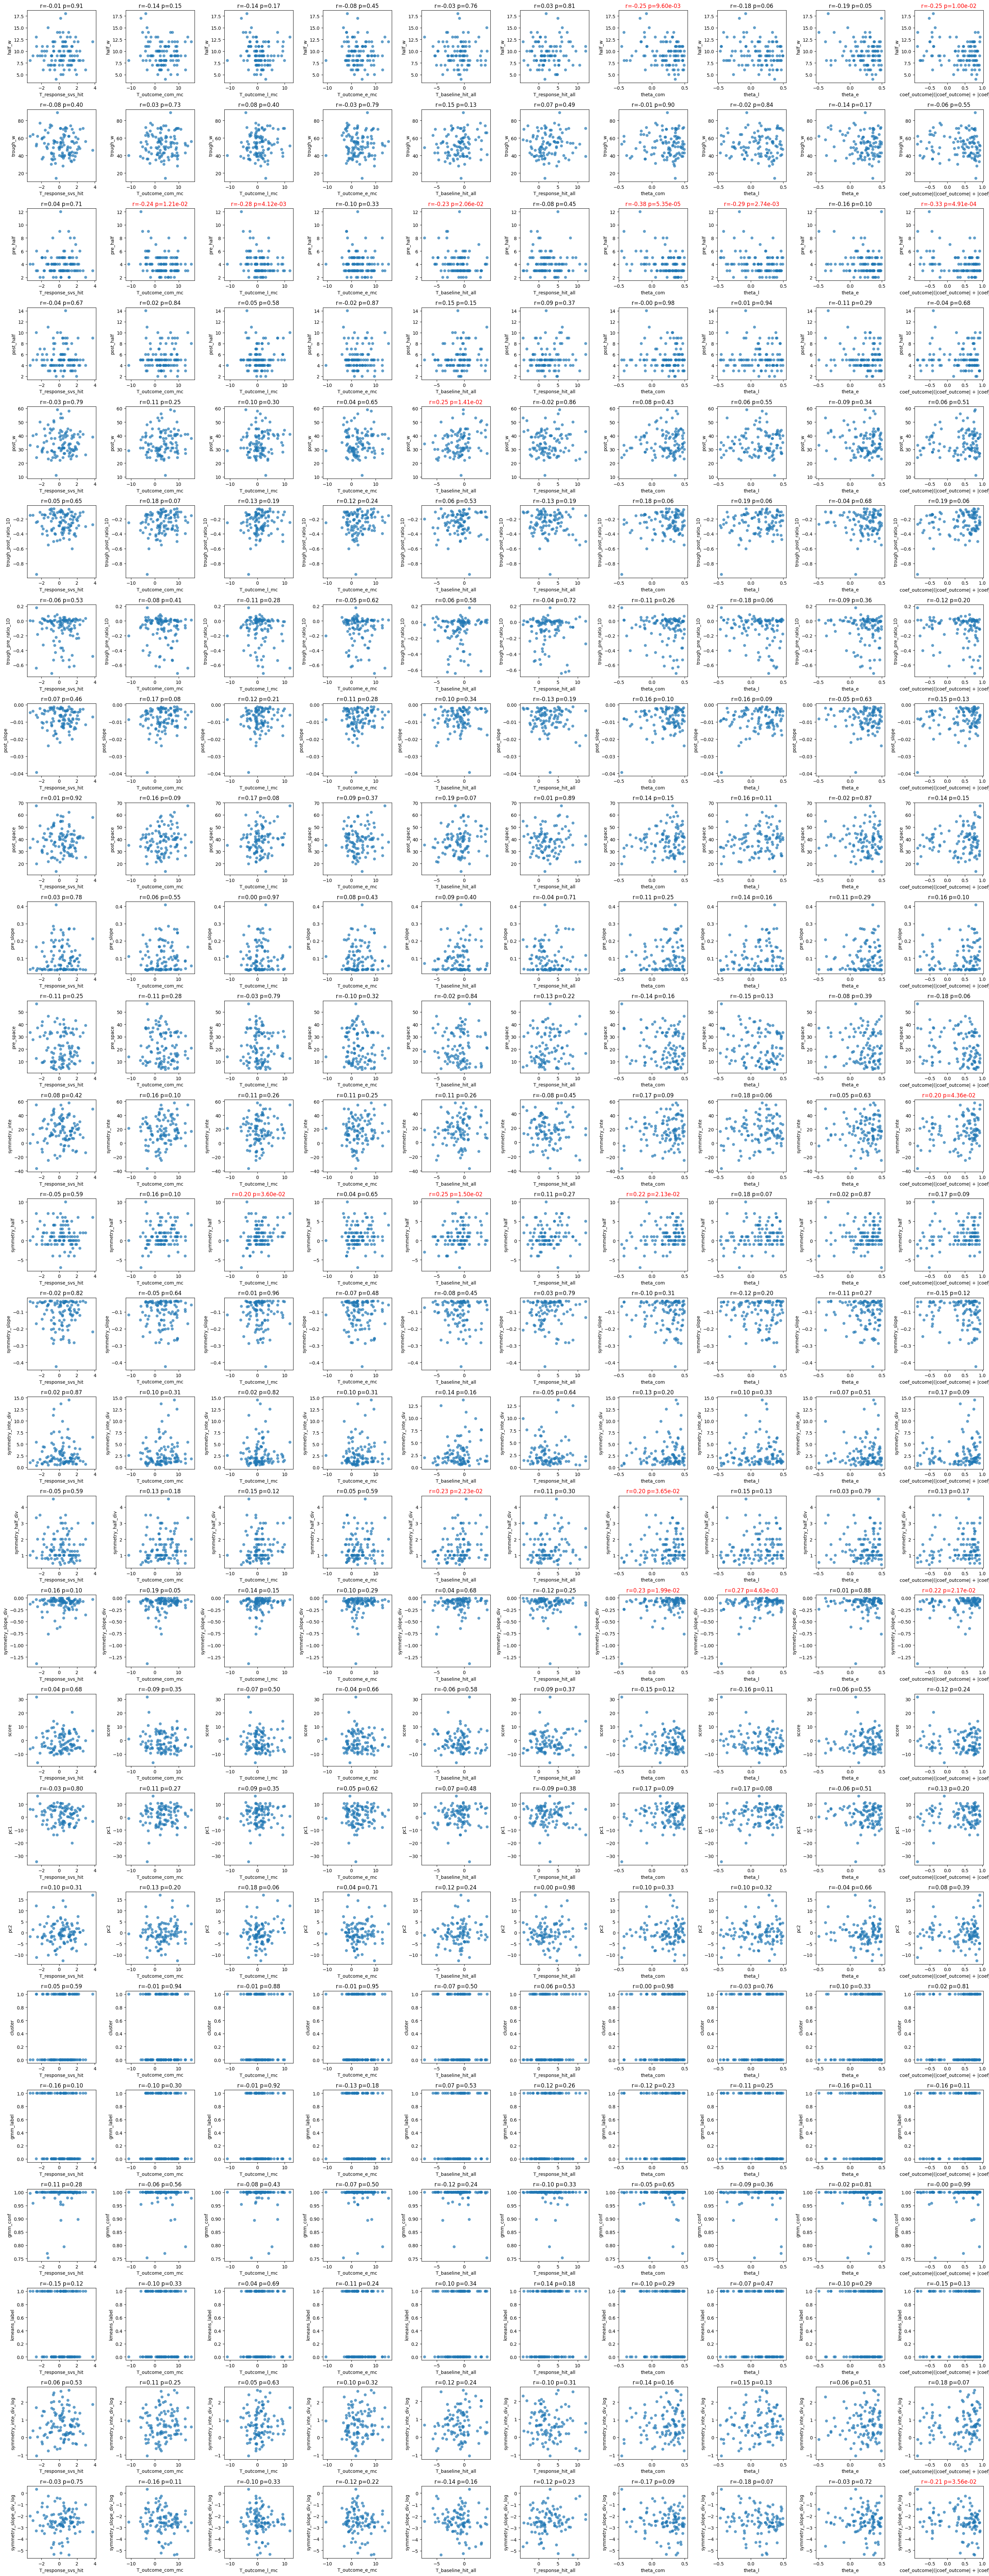

In [ ]:
# compare all values in features_be with features_wf
filter = features_combined['be_filter']
fig = plt.figure(figsize=(len(features_beh) * 3, 3 * len(features_wf)))
gs = gridspec.GridSpec(len(features_wf), len(features_beh))
for i, feature in enumerate(features_wf):
    for j, feature_be in enumerate(features_beh):
        ax = fig.add_subplot(gs[i, j])
        ax.scatter(features_combined[feature_be][filter], features_combined[feature][filter], s=40, alpha=0.7, edgecolor='none')
        
        ax.set_xlabel(feature_be)
        ax.set_ylabel(feature)
        # correlation 
        x = features_combined[feature_be][filter]
        y = features_combined[feature][filter]
        corr, p = stats.pearsonr(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)])
        ax.set_title(f'r={corr:.2f} p={p:.2f}')
        if p < 0.05:
            ax.set_title(f'r={corr:.2f} p={p:.2e}', color='red')
plt.tight_layout()
plt.savefig(os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.png'), bbox_inches='tight')

In [ ]:
os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf')

'/root/capsule/scratch/combined/beh_plots/beh_all/compare_beh_wf_features_beh_all_waveform_all_raw.pdf'

# Compare with basic properties

In [ ]:
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
features_be = basic_ephys_df.columns.to_list()
features_be.remove('session')
features_be.remove('unit_id')
features_be.remove('acg')
features_be.remove('acg_bl')
features_be.remove('be_filter')

In [ ]:
# compare all values in features_be with features_wf
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
fig = plt.figure(figsize=(len(features_beh) * 3, 3 * len(features_be)))
gs = gridspec.GridSpec(len(features_be), len(features_beh))
for i, feature in enumerate(features_be):
    for j, feature_be in enumerate(features_beh):
        ax = fig.add_subplot(gs[i, j])
        ax.scatter(features_combined[feature_be][filter], features_combined[feature][filter], c=features_combined['cluster'][filter], cmap='viridis', s=40, alpha=0.7, edgecolor='none')
        
        ax.set_xlabel(feature_be)
        ax.set_ylabel(feature)
        # correlation 
        x = features_combined[feature_be][filter].values
        y = features_combined[feature][filter].values
        corr, p = stats.pearsonr(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)])
        ax.set_title(f'r={corr:.2f} p={p:.2f}')
        if p < 0.05:
            ax.set_title(f'r={corr:.2f} p={p:.2e}', color='red')
plt.tight_layout()
plt.savefig(os.path.join(beh_folder, f'compare_beh_basicephys_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'compare_beh_basicephys_features_{criteria_name}_{waveform_criteria}{waveform_type}.png'), bbox_inches='tight')


# Compare outcome and go cue response